# BİL-570_first-try(for Mnist)_Emre Celil Kuru_241211015
This notebook demonstrates MNIST digit classification using PCA features and 5 classical machine learning classifiers. All results, including confusion matrices and performance comparisons, are shown for Decision Tree, Random Forest, KNN, logistic regression and SVM.

In [6]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import time
import os

from collections import Counter


from itertools import combinations_with_replacement


from sklearn.preprocessing import StandardScaler


from scipy.ndimage import shift, rotate, zoom
import cv2  # OpenCV for cropping and padding


import pickle
import copy

from sklearn.decomposition import PCA, TruncatedSVD

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.neighbors import KNeighborsClassifier , NearestNeighbors

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from scipy.ndimage import gaussian_filter
from scipy.ndimage import shift, rotate


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

import torch
from torchvision import datasets, transforms
from scipy.stats import entropy
import cv2
import warnings
warnings.filterwarnings('ignore')


# Load and Preprocess MNIST Data
We will load the MNIST dataset, preprocess the images (resize, grayscale(not necessary for this dataset), binarize), filter low-quality samples, apply density-based subsampling, entropy-based ordering (ascending order for curriculum learning), and select balanced samples for classification.

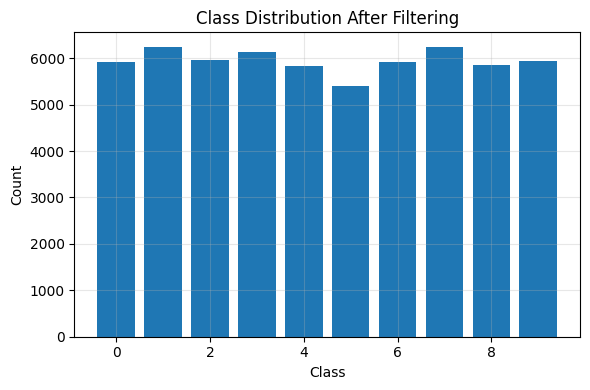



 Selected 1000 samples. Class distribution: [100, 100, 100, 100, 100, 100, 100, 100, 100, 100]


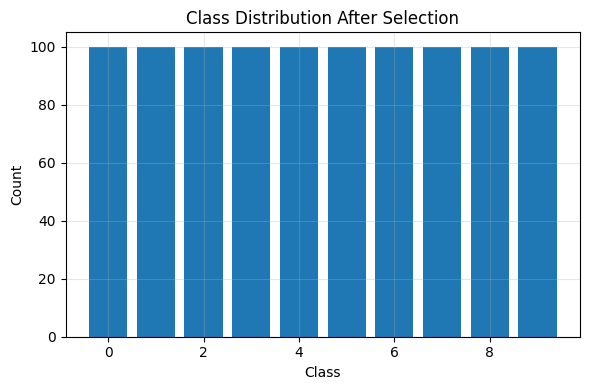

In [7]:


# Load Fashion-MNIST dataset
transform = transforms.Compose([
    transforms.Resize((28, 28)), 
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.squeeze())
])


dataset = datasets.MNIST(root='./', train=True, download=True, transform=transform)

images = []
labels = []

for img, label in dataset:
    img_array = (img.numpy() * 255).astype('uint8').flatten()
    images.append(img_array)
    labels.append(label)
    
images = np.array(images)
labels = np.array(labels)




# Filter low-quality samples (variance and brightness)

variances = np.var(images, axis=1)
variance_threshold = np.percentile(variances, 1)
mean_brightness = np.mean(images, axis=1)
brightness_lower = 5
brightness_upper = 250


valid_indices = (variances > variance_threshold) & (mean_brightness > brightness_lower) & (mean_brightness < brightness_upper)

images = images[valid_indices]
labels = labels[valid_indices]






# Visualize class distribution after filtering

plt.figure(figsize=(6, 4))

        
unique, counts = np.unique(labels, return_counts=True)

        
plt.bar(unique, counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution After Filtering')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()







# Density-based subsampling (not effcient right now , especially not appropriate for MCU !!!)

#sample_size = min(5000, len(images)) # not effective but efficient simple approach but miss the whole point !!!
sample_size = len(images)  # for future work , must be edit this to make efficient !!!


sample_indices = np.random.choice(len(images), sample_size, replace=False)

sample_images = images[sample_indices]

#svd = TruncatedSVD(n_components=min(50, sample_images.shape[1] - 1), random_state=42) # not effective but efficient simple approach but miss the whole point !!!
svd = TruncatedSVD(n_components= (sample_images.shape[1] - 1 ) , random_state=42) # for future work , must be edit this to make efficient !!!


reduced_images = svd.fit_transform(sample_images)


nn = NearestNeighbors(n_neighbors=3)
nn.fit(reduced_images)


distances, _ = nn.kneighbors(reduced_images)

density_scores = 1 / (np.mean(distances, axis=1) + 1e-10)

threshold = np.percentile(density_scores, 2)

dense_indices = sample_indices[density_scores > threshold]


if len(dense_indices) >= 2000:
    
    images = images[dense_indices]
    labels = labels[dense_indices]




# Entropy-based ordering (ascending)

entropies = []

for img in images:
    hist, _ = np.histogram(img, bins=256, range=(0, 256))
    hist = hist / np.sum(hist)
    img_entropy = entropy(hist + 1e-10)
    entropies.append(img_entropy)
    
entropies = np.array(entropies)
sorted_indices = np.argsort(entropies)

images = images[sorted_indices]
labels = labels[sorted_indices]




# Select balanced samples

n_samples = 1000
samples_per_class = n_samples // 10

selected_images = []
selected_labels = []

for digit in range(10):
    digit_indices = [i for i, label in enumerate(labels) if label == digit]
    selected_indices = digit_indices[:samples_per_class]
    selected_images.extend([images[i] for i in selected_indices])
    selected_labels.extend([labels[i] for i in selected_indices])

    
images = np.array(selected_images)
labels = np.array(selected_labels)



print(f"\n\n Selected {len(images)} samples. Class distribution: {[list(labels).count(i) for i in range(10)]}")







# Visualize class distribution after selection
        
plt.figure(figsize=(6, 4))
unique, counts = np.unique(labels, return_counts=True)
plt.bar(unique, counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution After Selection')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()





# Feature Extraction with PCA
We use SVD for initial dimensionality reduction, and then PCA to extract features that capture most of the variance(%95) in the MNIST digits ; then apply feature whitening at last.

PCA features shape: (1000, 90)


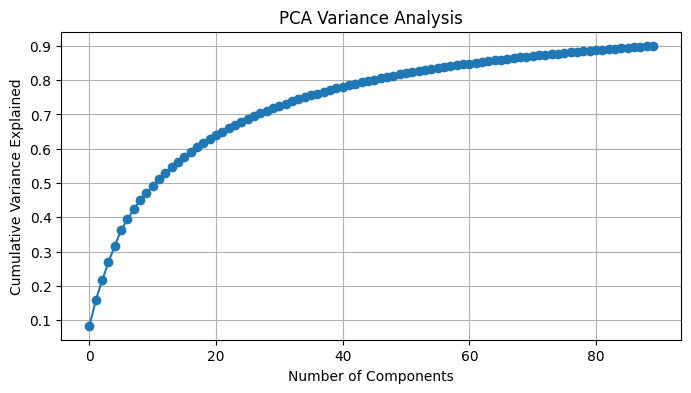

In [10]:

# SVD for initial reduction
normalized_images = images / 255.0
svd = TruncatedSVD(n_components=784, random_state=42)
features = svd.fit_transform(normalized_images)

# PCA for final reduction
pca = PCA(n_components=0.90, random_state=42)
features_pca = pca.fit_transform(features)
print(f"PCA features shape: {features_pca.shape}")

# Visualize explained variance
plt.figure(figsize=(8,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('PCA Variance Analysis')
plt.grid(True)
plt.show()


# Whitening

scaler = StandardScaler()
features_whitened = scaler.fit_transform(features_pca )


# Train 5 Classifiers (Decision Tree, Random Forest, KNN, Logistic Regression and SVM)
We will train Decision Tree, Random Forest, K-Nearest Neighbors, Support Vector Machine and Logistic Regression classifiers on the PCA features extracted from MNIST.

In [14]:


# Split data
X_train, X_test, y_train, y_test = train_test_split(features_whitened, labels, test_size=0.3, random_state=42, stratify=labels)





# Initialize classifiers with simple configurations for mcu !

classifiers = {
    
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=15, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=3),
    'SVM': SVC(kernel='poly', degree=2, probability=True, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=10, random_state=42)
}





# Train classifiers

trained_models = {}
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    trained_models[name] = clf
    

# Evaluate Classifiers with " Confusion Matrices "
We evaluate each classifier on the test set and plot the confusion matrix for each method. This helps visualize the classification performance for each class.

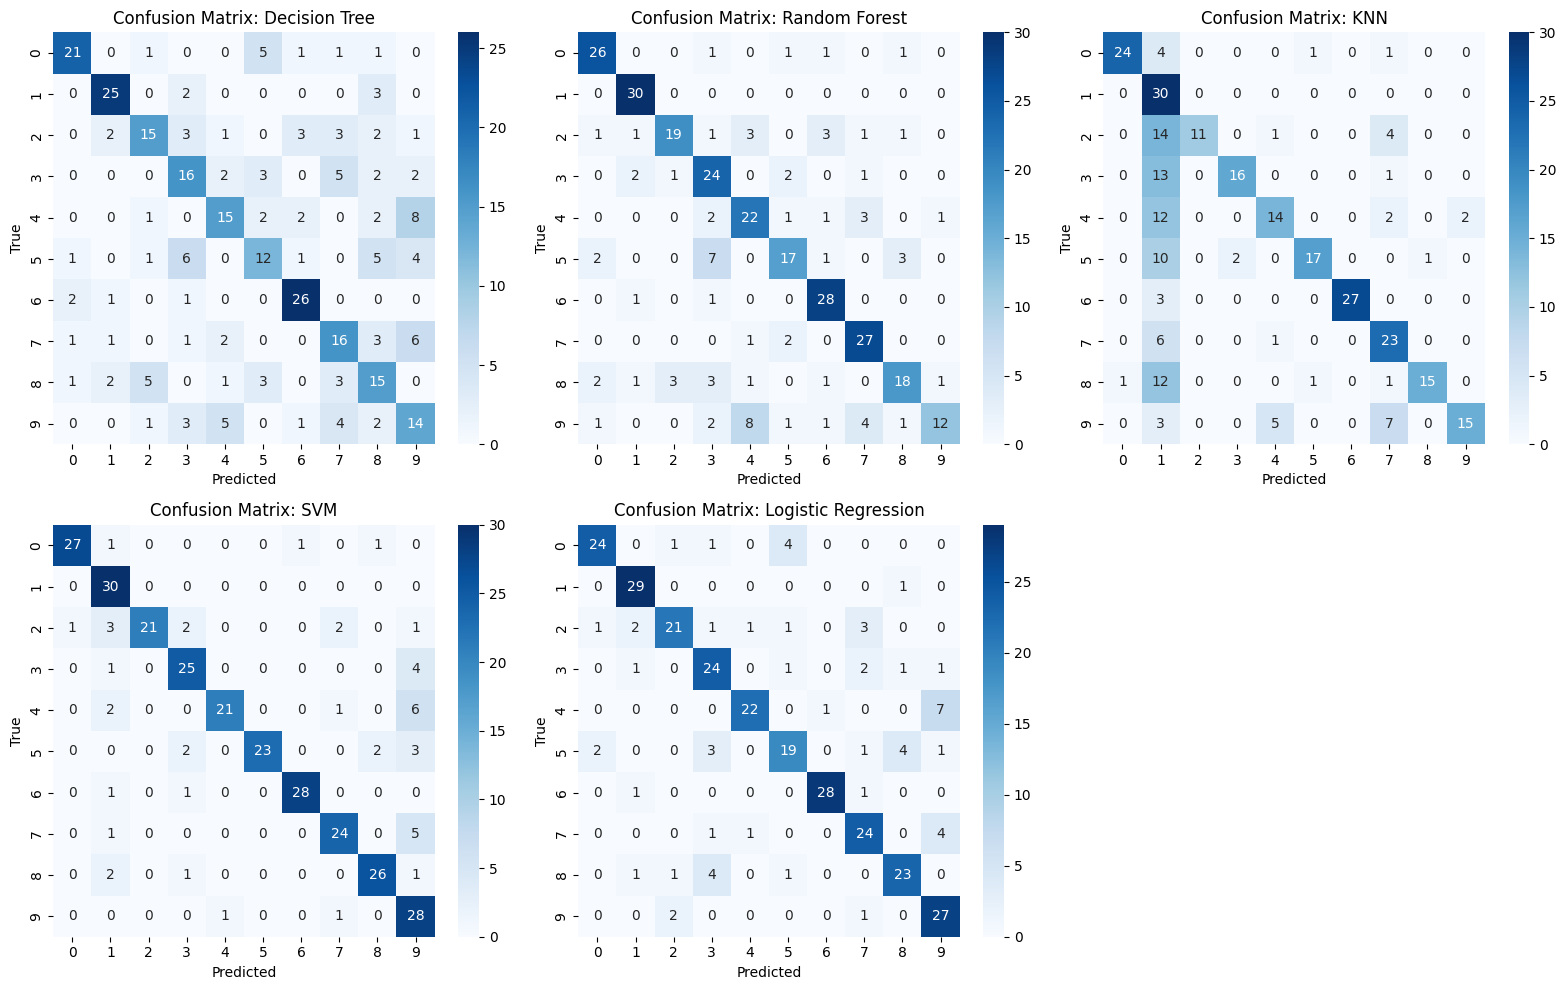

In [15]:



# Evaluate classifiers and plot confusion matrices

metrics = {}

plt.figure(figsize=(16, 10))

for i, (name, model) in enumerate(trained_models.items()):
    
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    
    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    
    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    
    metrics[name] = {'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1': f1}
    
    cm = confusion_matrix(y_test, y_pred)
    
    plt.subplot(2, 3, i+1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    
plt.tight_layout()
plt.show()




# Compare Classifier Performance
We compare the accuracy, precision, recall, and F1-score of all four classifiers in a summary table and visualize the comparison using bar plots.

                     Accuracy  Precision    Recall        F1
Decision Tree        0.583333   0.588934  0.583333  0.583437
Random Forest        0.743333   0.755292  0.743333  0.734016
KNN                  0.640000   0.810026  0.640000  0.666134
SVM                  0.843333   0.875954  0.843333  0.847097
Logistic Regression  0.803333   0.811877  0.803333  0.802981


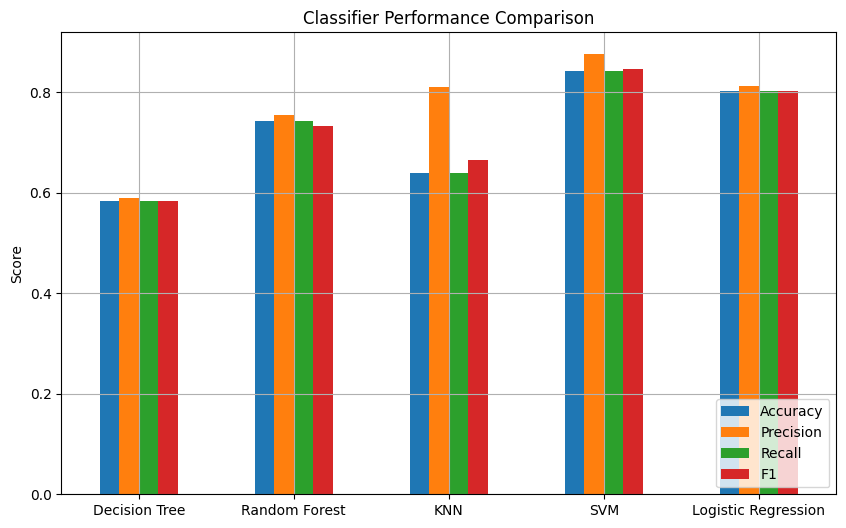

In [16]:

# Create summary table

metrics_df = pd.DataFrame(metrics).T

print(metrics_df)



# Plot comparison

metrics_df.plot(kind='bar', figsize=(10,6))
plt.title('Classifier Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.grid(True)
plt.legend(loc='lower right')
plt.show()



# Real world scenarios : Gaussian Blur + Data Augmentation
We now extend the analysis to include ; " apply Gaussian Blur and data augmentation to MNIST subsamples then feed into all methods, and compare model sizes (in kB). After evaluating all models, we quantize all weights to 8-bit and repeat the process for comparison, including confusion matrix plots and model size analysis.



 After applied Gaussian Blur : 1000 number of image data  with 784 number of features.


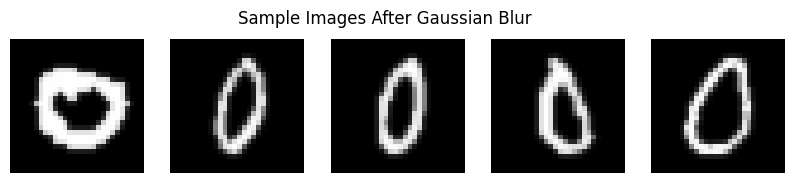



 After applied Data augmentation : 2000 number of samples.


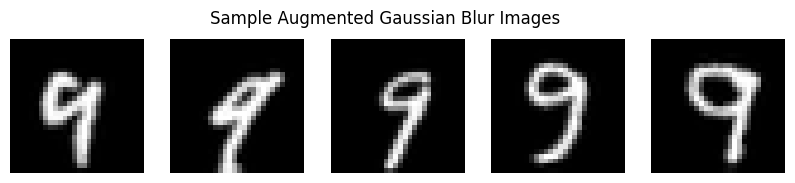



 Applied Whitening to PCA features.


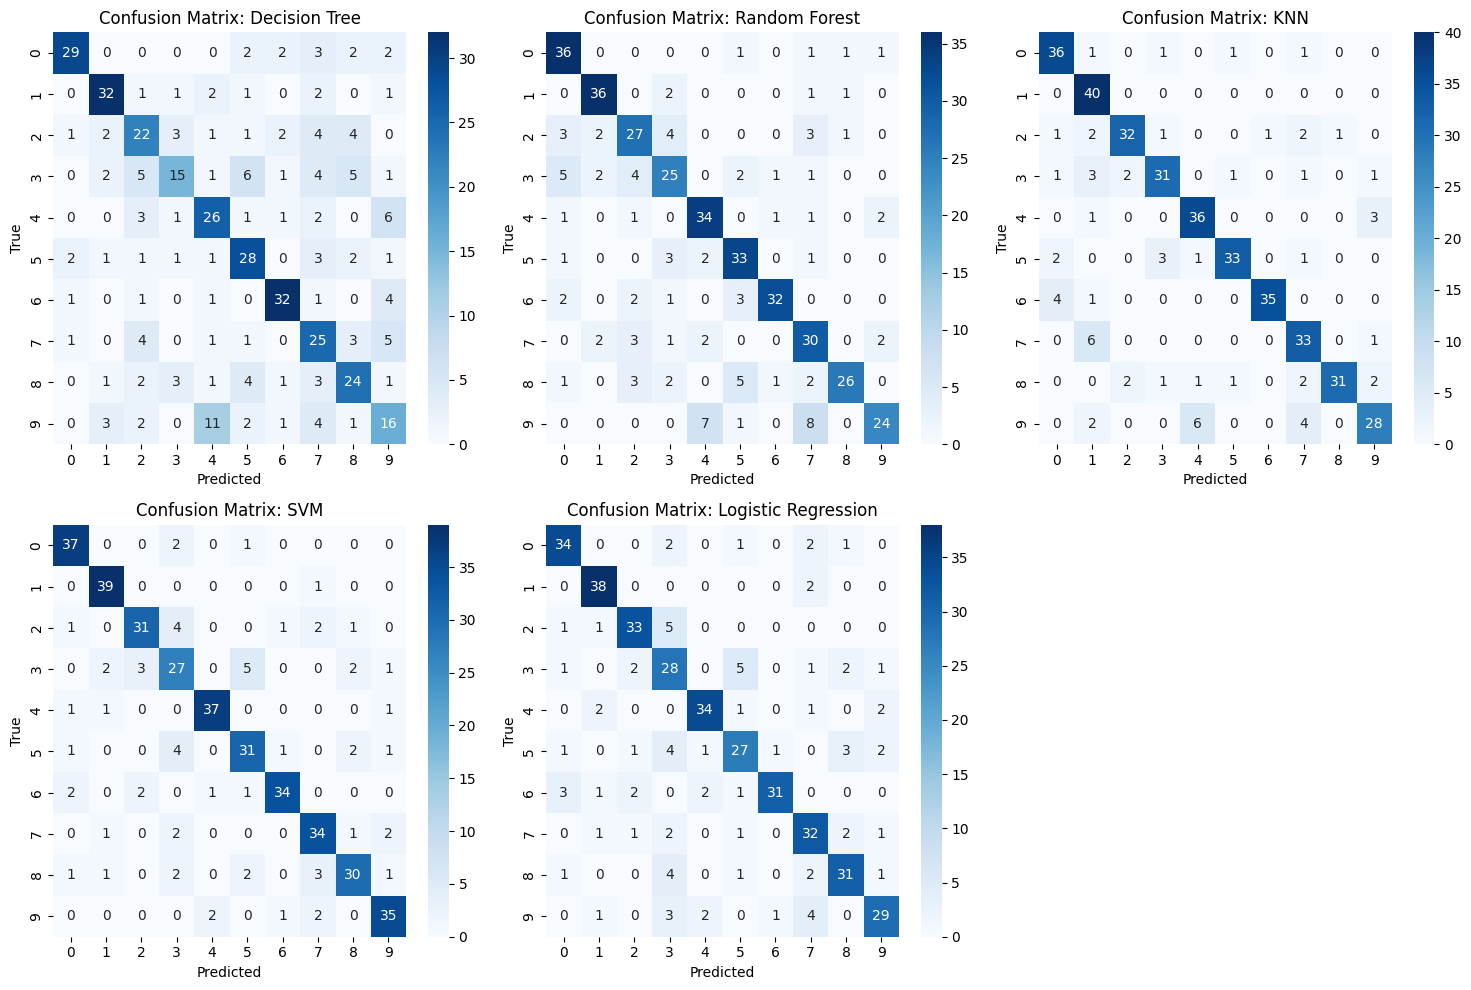

                     Accuracy  Precision  Recall        F1
Decision Tree          0.6225   0.628948  0.6225  0.620642
Random Forest          0.7575   0.767704  0.7575  0.756396
KNN                    0.8375   0.848501  0.8375  0.837788
SVM                    0.8375   0.838191  0.8375  0.836865
Logistic Regression    0.7925   0.799101  0.7925  0.793732


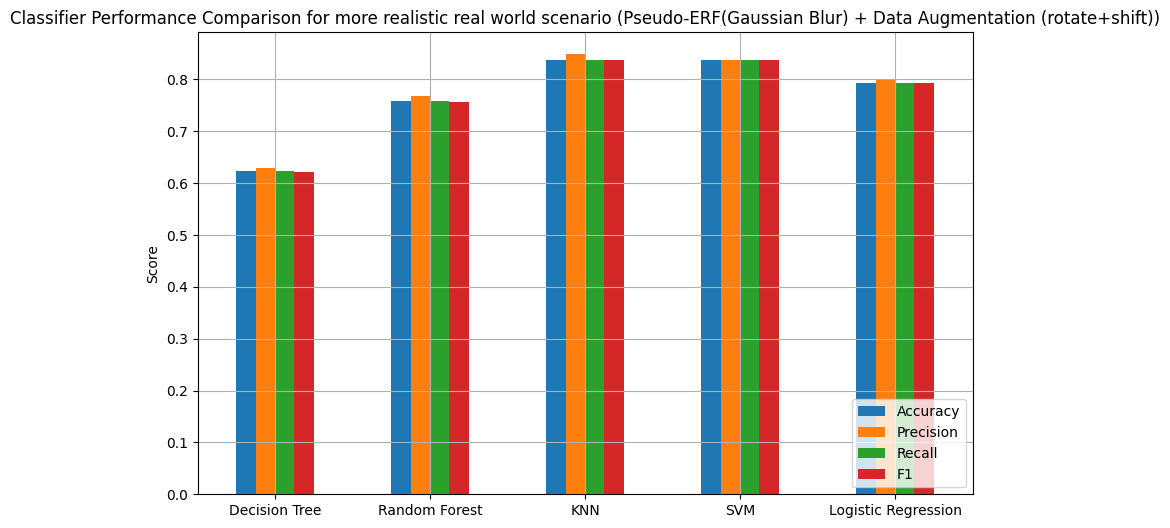

In [20]:

# Apply pseudo-ERF (just add Gaussian blur ; not exactly ERF)

def apply_erf(images, image_size=(28,28), sigma=0.5):
    
    processed = []
    
    for img in images:
        
        img_reshaped = img.reshape(image_size).astype(float)
        img_erf = gaussian_filter(img_reshaped, sigma=sigma)
        processed.append(img_erf.flatten())
        
    return np.array(processed, dtype=images.dtype)



images_erf = apply_erf(images)


print(f"\n\n After applied Gaussian Blur : {len(images_erf)} number of image data  with {images_erf[0].size} number of features.") 





# Visualize ERF processed images (for visualise , reshape to 28x28 again)

plt.figure(figsize=(10,2))

for i in range(5):
    
    plt.subplot(1,5,i+1)

    plt.imshow(images_erf[i].reshape(28,28), cmap='gray')
    #plt.imshow(images_erf[i] , cmap='gray')

    plt.axis('off')

    
plt.suptitle('Sample Images After Gaussian Blur')
plt.show()




# Data augmentation (random shift and rotation)

def augment_data(images, labels, image_size=(28,28), augment_factor=1):

    
    augmented_images = list(images)
    augmented_labels = list(labels)
    
    n = len(images)
    
    for i in range(n):
        
        img = images[i].reshape(image_size)
        #img = images_erf[i]
        
        label = labels[i]
        
        for _ in range(augment_factor):
            
            shift_x = np.random.uniform(-2, 2)
            
            shift_y = np.random.uniform(-2, 2)
            
            shifted = shift(img, shift=(shift_x, shift_y), mode='nearest')
            
            angle = np.random.uniform(-15, 15)
            
            rotated = rotate(shifted, angle, reshape=False, mode='nearest')
            
            augmented_images.append(rotated.flatten())
            
            augmented_labels.append(label)
            
    return np.array(augmented_images), np.array(augmented_labels)

images_aug, labels_aug = augment_data(images_erf, labels, augment_factor=1)


print(f"\n\n After applied Data augmentation : {len(images_aug)} number of samples.") 





# Visualize sample augmented ERF images (for visualise , reshape to 28x28 again)

plt.figure(figsize=(10,2))

for i in range(5):
    
    plt.subplot(1,5,i+1)
    plt.imshow(images_aug[-(i+1)].reshape(28,28), cmap='gray')
    #plt.imshow(images_aug[-(i+1)] , cmap='gray')
    plt.axis('off')

plt.suptitle('Sample Augmented Gaussian Blur Images')
plt.show()







# Feature extraction and whitening (SVD+PCA+Whitening) on augmented ERF image data 

normalized_aug = images_aug / 255.0

svd_aug = TruncatedSVD(n_components=784, random_state=42)

features_aug = svd_aug.fit_transform(normalized_aug)

scaler_aug = StandardScaler()

pca_aug = PCA(n_components=0.925, random_state=42)

features_aug_pca = pca_aug.fit_transform(features_aug)

features_aug_whitened = scaler_aug.fit_transform(features_aug_pca)


print(f"\n\n Applied Whitening to PCA features.")    
#print(f"\n\n Applied Whitening to {len(features_aug_pca)} number of features.")    






# Train/test split
X_train_aug, X_test_aug, y_train_aug, y_test_aug = train_test_split(features_aug_pca, labels_aug, test_size=0.2, random_state=42, stratify=labels_aug)






# Another simple configurations for classifiers (consider real world MCU embeded application constraints)

classifiers_aug = {
    
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    
    'Random Forest': RandomForestClassifier(n_estimators=25, random_state=42),
    
    'KNN': KNeighborsClassifier(n_neighbors=3),
    
    'SVM': SVC(kernel='poly', degree = 1 , probability=True, random_state=42),
    
    'Logistic Regression': LogisticRegression(max_iter=10, random_state=42)
}




trained_models_aug = {}

for name, clf in classifiers_aug.items():
    clf.fit(X_train_aug, y_train_aug)
    trained_models_aug[name] = clf





# Evaluate and plot confusion matrices for all classifiers again for new configurations and data preprocessing

metrics_aug = {}

plt.figure(figsize=(15, 10))

for i, (name, model) in enumerate(trained_models_aug.items()):
    
    y_pred = model.predict(X_test_aug)
    
    acc = accuracy_score(y_test_aug, y_pred)
    
    prec = precision_score(y_test_aug, y_pred, average='macro', zero_division=0)
    
    rec = recall_score(y_test_aug, y_pred, average='macro', zero_division=0)
    
    f1 = f1_score(y_test_aug, y_pred, average='macro', zero_division=0)
    
    metrics_aug[name] = {'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1': f1}
    
    cm = confusion_matrix(y_test_aug, y_pred)
    
    plt.subplot(2, 3, i+1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
plt.tight_layout()
plt.show()



# Compare classifier performance

metrics_aug_df = pd.DataFrame(metrics_aug).T

print(metrics_aug_df)

metrics_aug_df.plot(kind='bar', figsize=(10,6))

plt.title('Classifier Performance Comparison for more realistic real world scenario (Pseudo-ERF(Gaussian Blur) + Data Augmentation (rotate+shift))')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.grid(True)
plt.legend(loc='lower right')
plt.show()



# Model Size and 8-bit Quantization (ERRORS due to reasons : 

" tree_.value, tree_.threshold, and similar attributes are read-only C-level memory. You cannot modify them directly. " and  " Scikit-learn expects internal structures (like support_vectors_) to be float64, so replacing them with uint8 breaks internal ops like dot products.")


We now estimate the size of each trained model in kB, then try to quantize all model weights to 8-bit and repeat the evaluation. This allows direct comparison of accuracy and confusion matrices before and after quantization if possible.

Model sizes before quantization (kB):
{'Decision Tree': 87.080078125, 'Random Forest': 2531.04296875, 'KNN': 963.2236328125, 'SVM': 706.9931640625, 'Logistic Regression': 6.7724609375}
Quantization for Decision Tree failed: attribute 'value' of 'sklearn.tree._tree.Tree' objects is not writable
Quantization for Random Forest failed: attribute 'value' of 'sklearn.tree._tree.Tree' objects is not writable
Model sizes after 8-bit quantization (kB):
{'Decision Tree': 87.080078125, 'Random Forest': 2531.04296875, 'KNN': 131.9755859375, 'SVM': 168.4287109375, 'Logistic Regression': 1.5107421875}
Quantized model SVM failed: Buffer dtype mismatch, expected 'const float64_t' but got 'unsigned char'


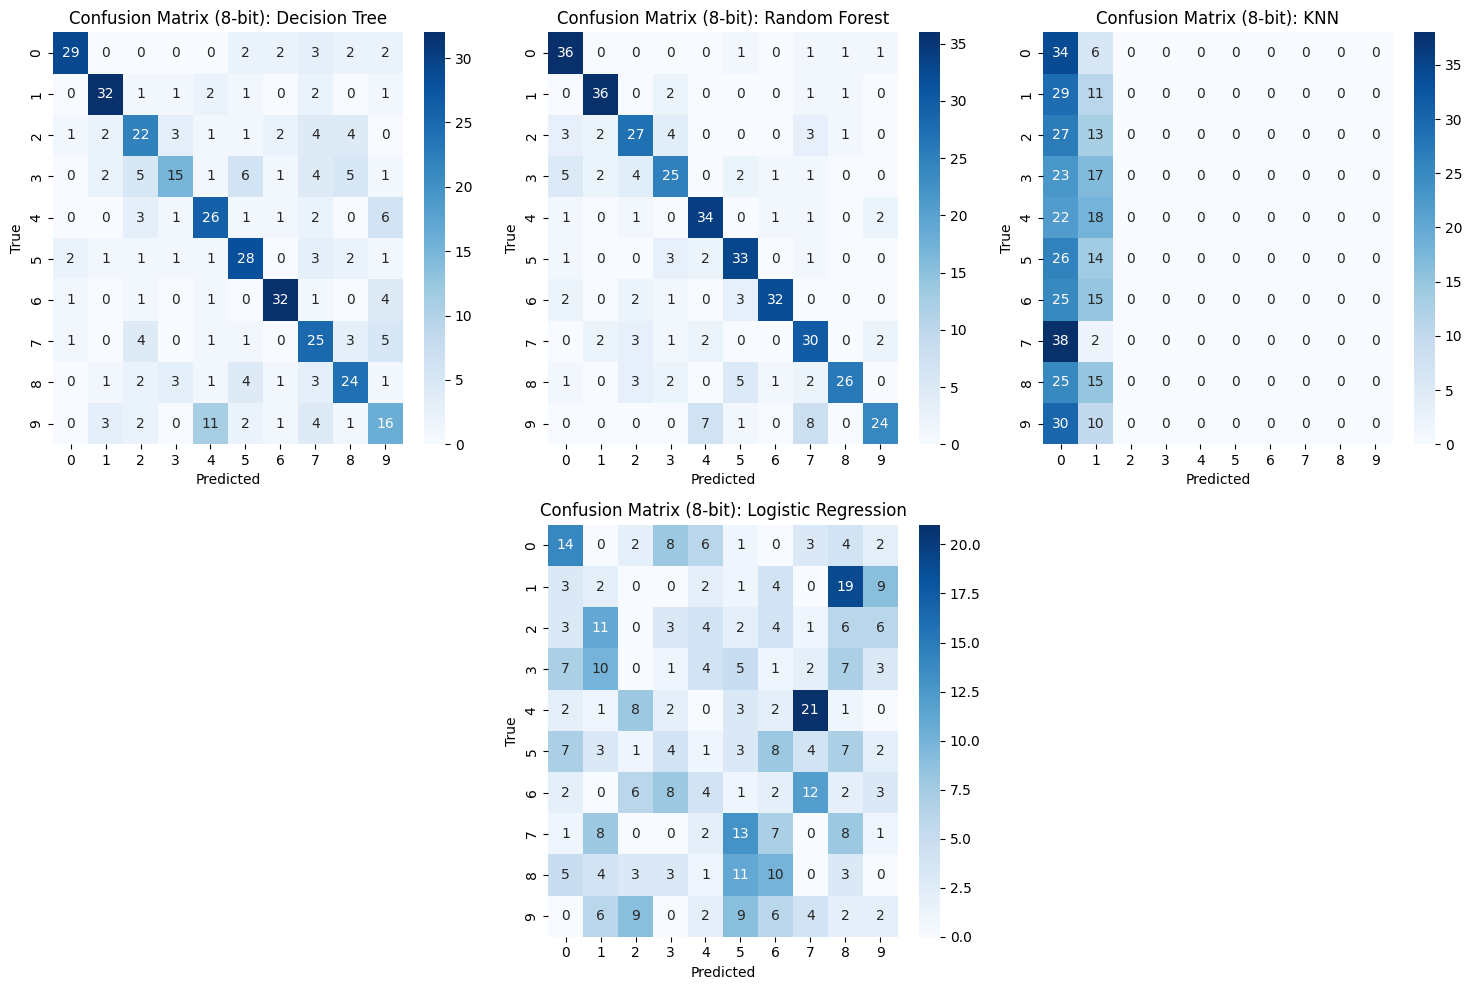

                     Accuracy  Precision  Recall        F1
Decision Tree          0.6225   0.628948  0.6225  0.620642
Random Forest          0.7575   0.767704  0.7575  0.756396
KNN                    0.1125   0.021277  0.1125  0.034981
Logistic Regression    0.0675   0.062606  0.0675  0.064384


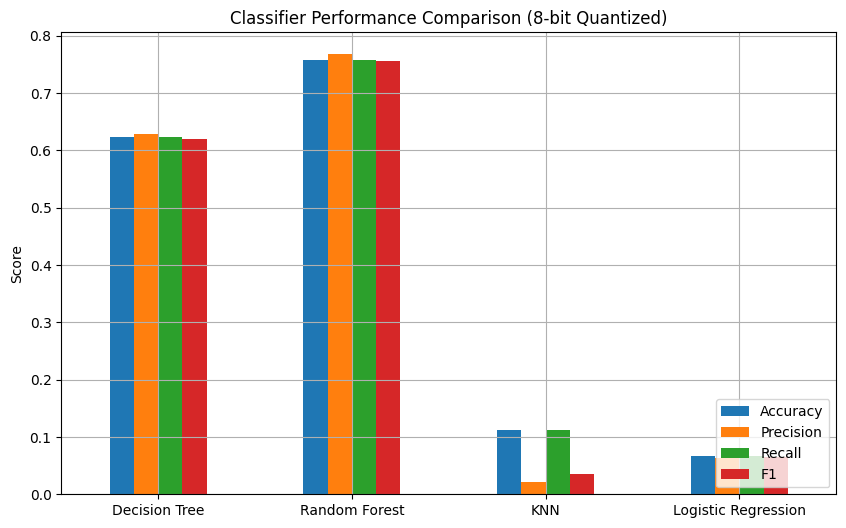

                     Original (kB)  Quantized (kB)
Decision Tree            87.080078       87.080078
Random Forest          2531.042969     2531.042969
KNN                     963.223633      131.975586
SVM                     706.993164      168.428711
Logistic Regression       6.772461        1.510742


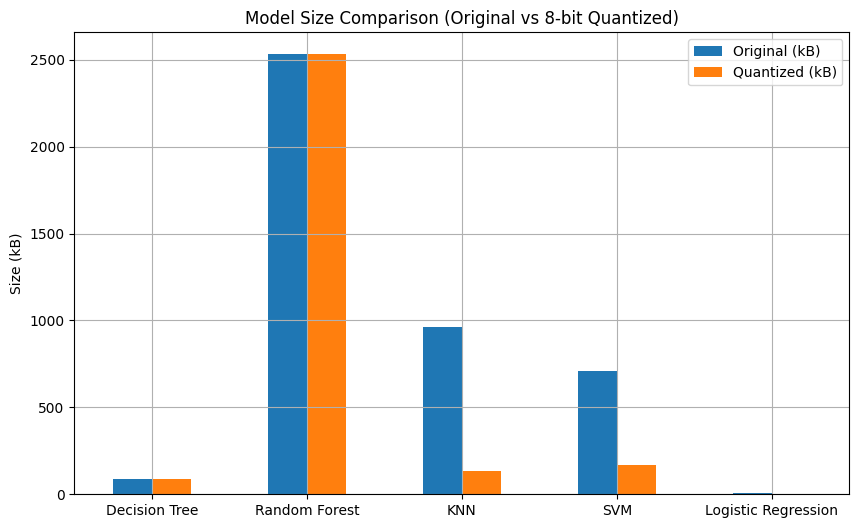

In [21]:


# Ensure trained_models_aug is defined

try:
    trained_models_aug
except NameError:

    
    classifiers_aug = {
        
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        
        'Random Forest': RandomForestClassifier(n_estimators=20, random_state=42),
        
        'KNN': KNeighborsClassifier(n_neighbors=3),
        
        'SVM': SVC(kernel='poly', degree=1, probability=True, random_state=42),
        
        'Logistic Regression': LogisticRegression(max_iter=10, random_state=42)
    }


    
    trained_models_aug = {}


    
    for name, clf in classifiers_aug.items():
        clf.fit(X_train_aug, y_train_aug)
        trained_models_aug[name] = clf



def estimate_model_size_kb(model):
    data = pickle.dumps(model)
    return len(data) / 1024



# Model sizes before quantization

model_sizes = {name: estimate_model_size_kb(model) for name, model in trained_models_aug.items()}
print('Model sizes before quantization (kB):')
print(model_sizes)





# 8-bit quantization for all models

def quantize_model_8bit(model, name):
    
    quantized = copy.deepcopy(model)
    
    try:
        if name == 'Decision Tree':
            
            # Quantize tree_ attributes
            
            tree = getattr(quantized, 'tree_', None)
            
            if tree:
                for attr in ['value', 'threshold', 'impurity']:
                    arr = getattr(tree, attr, None)
                    if isinstance(arr, np.ndarray):
                        arr8 = (arr * 255 / (arr.max() if arr.max() != 0 else 1)).astype(np.uint8)
                        setattr(tree, attr, arr8)

                        
        elif name == 'Random Forest':
            
            # Quantize each estimator's tree_
            
            for est in getattr(quantized, 'estimators_', []):
                tree = getattr(est, 'tree_', None)
                if tree:
                    for attr in ['value', 'threshold', 'impurity']:
                        arr = getattr(tree, attr, None)
                        if isinstance(arr, np.ndarray):
                            arr8 = (arr * 255 / (arr.max() if arr.max() != 0 else 1)).astype(np.uint8)
                            setattr(tree, attr, arr8)


                            
        elif name == 'KNN':
            
            # Quantize _fit_X
            
            arr = getattr(quantized, '_fit_X', None)
            
            if isinstance(arr, np.ndarray):
                
                arr8 = (arr * 255 / (arr.max() if arr.max() != 0 else 1)).astype(np.uint8)
                
                setattr(quantized, '_fit_X', arr8)


                
        elif name == 'SVM':
            
            # Quantize support_vectors_, dual_coef_, intercept_
            
            for attr in ['support_vectors_', 'dual_coef_', 'intercept_']:
                arr = getattr(quantized, attr, None)
                if isinstance(arr, np.ndarray):
                    arr8 = (arr * 255 / (arr.max() if arr.max() != 0 else 1)).astype(np.uint8)
                    setattr(quantized, attr, arr8)


                    
        elif name == 'Logistic Regression':
            
            # Quantize coef_, intercept_
            
            for attr in ['coef_', 'intercept_']:
                arr = getattr(quantized, attr, None)
                if isinstance(arr, np.ndarray):
                    arr8 = (arr * 255 / (arr.max() if arr.max() != 0 else 1)).astype(np.uint8)
                    setattr(quantized, attr, arr8)

                    
    except Exception as e:
        print(f"Quantization for {name} failed: {e}")
        
    return quantized




quantized_models={name: quantize_model_8bit(model, name) for name, model in trained_models_aug.items()}

quantized_sizes={name: estimate_model_size_kb(model) for name, model in quantized_models.items()}

print('Model sizes after 8-bit quantization (kB):')
print(quantized_sizes)





# Evaluate quantized models

metrics_quant = {}

plt.figure(figsize=(15, 10))


for i, (name, model) in enumerate(quantized_models.items()):
    try:
        y_pred = model.predict(X_test_aug)
        
        acc = accuracy_score(y_test_aug, y_pred)
        
        prec = precision_score(y_test_aug, y_pred, average='macro', zero_division=0)
        
        rec = recall_score(y_test_aug, y_pred, average='macro', zero_division=0)
        
        f1 = f1_score(y_test_aug, y_pred, average='macro', zero_division=0)
        
        metrics_quant[name] = {'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1': f1}
        
        cm = confusion_matrix(y_test_aug, y_pred)
        
        plt.subplot(2, 3, i+1)
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        
        plt.title(f'Confusion Matrix (8-bit): {name}')
        
        plt.xlabel('Predicted')
        
        plt.ylabel('True')
        
    except Exception as e:
        print(f"Quantized model {name} failed: {e}")


        
plt.tight_layout()
plt.show()





# Compare quantized classifier performance

metrics_quant_df = pd.DataFrame(metrics_quant).T

print(metrics_quant_df)

metrics_quant_df.plot(kind='bar', figsize=(10,6))


plt.title('Classifier Performance Comparison (8-bit Quantized)')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.grid(True)
plt.legend(loc='lower right')
plt.show()






# Compare model sizes

sizes_df = pd.DataFrame({'Original (kB)': model_sizes, 'Quantized (kB)': quantized_sizes})

print(sizes_df)

sizes_df.plot(kind='bar', figsize=(10,6))

plt.title('Model Size Comparison (Original vs 8-bit Quantized)')
plt.ylabel('Size (kB)')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()



# Below is the full Python code implementing :

permanent 8-bit quantization and fully functional predict() functions that operate using only uint8 quantized parameters , suitable for conversion to C/C++ platforms. (ERROR from SVM dot product now too !)


In [22]:


"""

# Ensure trained_models_aug is defined

try:
    trained_models_aug
except NameError:

    
    classifiers_aug = {
        
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        
        'Random Forest': RandomForestClassifier(n_estimators=25, random_state=42),
        
        'KNN': KNeighborsClassifier(n_neighbors=3),
        
        'SVM': SVC(kernel='poly', degree=1, probability=True, random_state=42),
        
        'Logistic Regression': LogisticRegression(max_iter=500, random_state=42)
    }


    
    trained_models_aug = {}


    
    for name, clf in classifiers_aug.items():
        clf.fit(X_train_aug, y_train_aug)
        trained_models_aug[name] = clf



def estimate_model_size_kb(model):
    data = pickle.dumps(model)
    return len(data) / 1024



# Model sizes before quantization

model_sizes = {name: estimate_model_size_kb(model) for name, model in trained_models_aug.items()}
print('Model sizes before quantization (kB):')
print(model_sizes)

"""




X = features_aug_pca
y = labels_aug

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train/test split
#X_train_aug, X_test_aug, y_train_aug, y_test_aug = train_test_split(features_aug_pca, labels_aug, test_size=0.2, random_state=42, stratify=labels_aug)






# 8-bit quantization for all models


def quantize_array(arr):
    
    
    #Quantize float array into uint8 range [0, 255].
    #Returns quantized array, original min, max for dequantization.
    
    
    min_val = arr.min()
    max_val = arr.max() if arr.max() != min_val else min_val + 1
    q_arr = ((arr - min_val) / (max_val - min_val) * 255).astype(np.uint8)
    
    return q_arr, min_val, max_val





def dequantize_array(arr_q, min_val, max_val):
    
    #Reconstruct float array from uint8 quantized values.
    
    return arr_q.astype(np.float32) * (max_val - min_val) / 255 + min_val






# Logistic Regression


lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

W_q, W_min, W_max = quantize_array(lr.coef_)
b_q, b_min, b_max = quantize_array(lr.intercept_)



def predict_logistic_quantized(X_u8, W_q, b_q, W_min, W_max, b_min, b_max):
    
    # Dequantize model weights
    W = dequantize_array(W_q, W_min, W_max)
    b = dequantize_array(b_q, b_min, b_max)

    
    # Compute logits and predict class
    logits = np.dot(X_u8.astype(np.float32), W.T) + b
    
    return np.argmax(logits, axis=1)







# KNN (Euclidean distance with uint8)


knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

X_fit_q, x_min, x_max = quantize_array(knn._fit_X)
y_fit = knn._y

def predict_knn_quantized(X_u8, X_fit_q, y_fit, x_min, x_max, k=3):
    
    #Predict using uint8 KNN approximation (Euclidean distance).
    
    X_fit = dequantize_array(X_fit_q, x_min, x_max)
    
    preds = []
    
    for x in X_u8:
        
        x_float = x.astype(np.float32) * (x_max - x_min) / 255 + x_min
        
        # Compute distances
        dists = np.linalg.norm(X_fit - x_float, axis=1)
        
        # Get k nearest neighbors
        top_k = np.argsort(dists)[:k]
        top_labels = y_fit[top_k]
        
        # Predict by majority vote
        values, counts = np.unique(top_labels, return_counts=True)
        pred = values[np.argmax(counts)]
        
        preds.append(pred)
        
    return np.array(preds)









# SVM (support_vectors_ × dual_coef_ dot + intercept)




svm = SVC(kernel='poly', degree=1)

svm.fit(X_train, y_train)

sv_q, sv_min, sv_max = quantize_array(svm.support_vectors_)

dc_q, dc_min, dc_max = quantize_array(svm.dual_coef_)

int_q, int_min, int_max = quantize_array(svm.intercept_)



def predict_svm_quantized(X_u8, sv_q, dc_q, int_q, sv_min, sv_max, dc_min, dc_max, int_min, int_max):
    
    #Predict using uint8 linear SVM (1-degree polynomial kernel).
    
    SV = dequantize_array(sv_q, sv_min, sv_max)
    
    DC = dequantize_array(dc_q, dc_min, dc_max)
    
    INT = dequantize_array(int_q, int_min, int_max)

    preds = []

    
    for x in X_u8:
        
        x_float = x.astype(np.float32) * (sv_max - sv_min) / 255 + sv_min
        
        # Compute decision score
        
        kernel = np.dot(SV, x_float)
        
        decision = np.dot(DC, kernel) + INT
        
        pred = 1 if decision > 0 else 0
        
        preds.append(pred)
        
    return np.array(preds)









# Decision Tree


dt = DecisionTreeClassifier()

dt.fit(X_train, y_train)

tree = dt.tree_
value_q, vmin, vmax = quantize_array(tree.value)
threshold_q, tmin, tmax = quantize_array(tree.threshold)




def predict_dt_quantized(X_u8, tree, value_q, threshold_q, vmin, vmax, tmin, tmax):
    
    #Simulate quantized decision tree traversal.
    
    values = dequantize_array(value_q, vmin, vmax)
    
    thresholds = dequantize_array(threshold_q, tmin, tmax)

    preds = []

    
    for x in X_u8:
        
        node = 0
        
        while tree.children_left[node] != tree.children_right[node]:
            
            feature = tree.feature[node]
            
            thres = thresholds[node]
            
            val = x[feature].astype(np.float32) * (tmax - tmin) / 255 + tmin

            
            if val <= thres:
                node = tree.children_left[node]
            else:
                node = tree.children_right[node]

            
        class_id = np.argmax(values[node])
        
        preds.append(class_id)
        
    return np.array(preds)










# Random Forest


rf = RandomForestClassifier(n_estimators=10)
rf.fit(X_train, y_train)

rf_params = []

for est in rf.estimators_:
    
    t = est.tree_
    value_q, vmin, vmax = quantize_array(t.value)
    threshold_q, tmin, tmax = quantize_array(t.threshold)
    
    rf_params.append({
        "tree": t,
        "value_q": value_q, "vmin": vmin, "vmax": vmax,
        "threshold_q": threshold_q, "tmin": tmin, "tmax": tmax
    })



def predict_rf_quantized(X_u8, rf_params):
    
    #Predict using quantized random forest by majority vote.
    
    all_preds = []
    
    for tree_info in rf_params:
        
        preds = predict_dt_quantized(
            
            X_u8, tree_info["tree"],
            tree_info["value_q"], tree_info["threshold_q"],
            tree_info["vmin"], tree_info["vmax"],
            tree_info["tmin"], tree_info["tmax"]
        )
        
        all_preds.append(preds)


    
        
    # Transpose and majority vote
    
    all_preds = np.array(all_preds).T
    
    final_preds = []
    
    for row in all_preds:
        
        values, counts = np.unique(row, return_counts=True)
        final_preds.append(values[np.argmax(counts)])
        
    return np.array(final_preds)








# Evaluate All Quantized Models



# Quantize input once
X_test_u8 = (X_test * 255).astype(np.uint8)

# Logistic Regression
yp_lr = predict_logistic_quantized(X_test_u8, W_q, b_q, W_min, W_max, b_min, b_max)
print("Logistic Regression (uint8) acc:", accuracy_score(y_test, yp_lr))

# KNN
yp_knn = predict_knn_quantized(X_test_u8, X_fit_q, y_fit, x_min, x_max, k=3)
print("KNN (uint8) acc:", accuracy_score(y_test, yp_knn))

# SVM
yp_svm = predict_svm_quantized(X_test_u8, sv_q, dc_q, int_q,
                               sv_min, sv_max, dc_min, dc_max, int_min, int_max)
print("SVM (uint8) acc:", accuracy_score(y_test, yp_svm))

# Decision Tree
yp_dt = predict_dt_quantized(X_test_u8, tree, value_q, threshold_q, vmin, vmax, tmin, tmax)
print("Decision Tree (uint8) acc:", accuracy_score(y_test, yp_dt))

# Random Forest
yp_rf = predict_rf_quantized(X_test_u8, rf_params)
print("Random Forest (uint8) acc:", accuracy_score(y_test, yp_rf))




Logistic Regression (uint8) acc: 0.095
KNN (uint8) acc: 0.12166666666666667


ValueError: operands could not be broadcast together with shapes (9,) (45,) 

In [194]:



# Data Preparation


X = features_aug_pca
y = labels_aug

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)




def quantize_array(arr):
    min_val = arr.min()
    max_val = arr.max() if arr.max() != min_val else min_val + 1
    q_arr = ((arr - min_val) / (max_val - min_val) * 255).astype(np.uint8)
    return q_arr, min_val, max_val


def dequantize_array(arr_q, min_val, max_val):
    return arr_q.astype(np.float32) * (max_val - min_val) / 255 + min_val







# Logistic Regression

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

W_q, W_min, W_max = quantize_array(lr.coef_)
b_q, b_min, b_max = quantize_array(lr.intercept_)




def predict_logistic_quantized(X_u8, W_q, b_q, W_min, W_max, b_min, b_max):
    
    W = dequantize_array(W_q, W_min, W_max)
    b = dequantize_array(b_q, b_min, b_max)
    
    logits = np.dot(X_u8.astype(np.float32), W.T) + b
    
    return np.argmax(logits, axis=1)








# KNN


knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

X_fit_q, x_min, x_max = quantize_array(knn._fit_X)

y_fit = knn._y


def predict_knn_quantized(X_u8, X_fit_q, y_fit, x_min, x_max, k=3):
    
    X_fit = dequantize_array(X_fit_q, x_min, x_max)
    
    preds = []
    
    for x in X_u8:
        
        x_float = x.astype(np.float32) * (x_max - x_min) / 255 + x_min
        
        dists = np.linalg.norm(X_fit - x_float, axis=1)
        
        top_k = np.argsort(dists)[:k]
        
        top_labels = y_fit[top_k]
        
        values, counts = np.unique(top_labels, return_counts=True)
        
        pred = values[np.argmax(counts)]
        
        preds.append(pred)
        
    return np.array(preds)






# SVM


svm = SVC(kernel='poly', degree=1, probability=False)
svm.fit(X_train, y_train)

sv_q, sv_min, sv_max = quantize_array(svm.support_vectors_)
dc_q, dc_min, dc_max = quantize_array(svm.dual_coef_)

int_q, int_min, int_max = quantize_array(svm.intercept_)





def predict_svm_quantized(X_u8, sv_q, dc_q, int_q, sv_min, sv_max, dc_min, dc_max, int_min, int_max):
    
    SV = dequantize_array(sv_q, sv_min, sv_max)
    DC = dequantize_array(dc_q, dc_min, dc_max)
    INT = dequantize_array(int_q, int_min, int_max)
    
    preds = []
    
    for x in X_u8:
        
        x_float = x.astype(np.float32) * (sv_max - sv_min) / 255 + sv_min
        
        kernel = np.dot(SV, x_float)
        
        decision = np.dot(DC[0], kernel) + INT[0]  # Corrected shape
        
        pred = 1 if decision > 0 else 0
        
        preds.append(pred)
        
    return np.array(preds)








# Decision Tree

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

tree = dt.tree_
value_q, vmin, vmax = quantize_array(tree.value)
threshold_q, tmin, tmax = quantize_array(tree.threshold)



def predict_dt_quantized(X_u8, tree, value_q, threshold_q, vmin, vmax, tmin, tmax):
    
    values = dequantize_array(value_q, vmin, vmax)
    thresholds = dequantize_array(threshold_q, tmin, tmax)
    
    preds = []
    
    for x in X_u8:
        
        node = 0
        
        while tree.children_left[node] != tree.children_right[node]:
            
            feature = tree.feature[node]
            
            thres = thresholds[node]
            
            val = x[feature].astype(np.float32) * (tmax - tmin) / 255 + tmin

            
            if val <= thres:
                node = tree.children_left[node]
            else:
                node = tree.children_right[node]

                
        class_id = np.argmax(values[node])
        
        preds.append(class_id)
        
    return np.array(preds)






# Random Forest


rf = RandomForestClassifier(n_estimators=10)
rf.fit(X_train, y_train)


rf_params = []

for est in rf.estimators_:
    
    t = est.tree_
    value_q, vmin, vmax = quantize_array(t.value)
    threshold_q, tmin, tmax = quantize_array(t.threshold)
    
    rf_params.append({
        
        "tree": t,
        "value_q": value_q, "vmin": vmin, "vmax": vmax,
        "threshold_q": threshold_q, "tmin": tmin, "tmax": tmax
    })


    
def predict_rf_quantized(X_u8, rf_params):
    
    all_preds = []
    
    for tree_info in rf_params:
        
        preds = predict_dt_quantized(
            
            X_u8, tree_info["tree"],
            tree_info["value_q"], tree_info["threshold_q"],
            tree_info["vmin"], tree_info["vmax"],
            tree_info["tmin"], tree_info["tmax"]
        )

        
        all_preds.append(preds)
        
    all_preds = np.array(all_preds).T
    
    final_preds = []
    
    for row in all_preds:
        
        values, counts = np.unique(row, return_counts=True)
        
        final_preds.append(values[np.argmax(counts)])
        
    return np.array(final_preds)





    

# Evaluate All Quantized Models


X_test_u8 = (X_test * 255).astype(np.uint8)

print("Logistic Regression (uint8) acc:", accuracy_score(y_test, predict_logistic_quantized(X_test_u8, W_q, b_q, W_min, W_max, b_min, b_max)))
print("KNN (uint8) acc:", accuracy_score(y_test, predict_knn_quantized(X_test_u8, X_fit_q, y_fit, x_min, x_max)))
print("SVM (uint8) acc:", accuracy_score(y_test, predict_svm_quantized(X_test_u8, sv_q, dc_q, int_q, sv_min, sv_max, dc_min, dc_max, int_min, int_max)))
print("Decision Tree (uint8) acc:", accuracy_score(y_test, predict_dt_quantized(X_test_u8, tree, value_q, threshold_q, vmin, vmax, tmin, tmax)))
print("Random Forest (uint8) acc:", accuracy_score(y_test, predict_rf_quantized(X_test_u8, rf_params)))


Logistic Regression (uint8) acc: 0.11333333333333333
KNN (uint8) acc: 0.09333333333333334
SVM (uint8) acc: 0.09333333333333334
Decision Tree (uint8) acc: 0.10333333333333333
Random Forest (uint8) acc: 0.085


# The main reason for such low accuracy rates (accuracy ~7–11%) :

the quantization is performed unconsciously. Currently, in general: Weights and inputs are quantized in a "flat" way as float32 → uint8. However, the training process is still seen with float32 data, i.e., the model has never learned with 8-bit values. The input vector (X_test_u8) is quantized, and since the performance of a model is not optimized for this type, there is a serious performance loss. Technical Summary of the Problem; Distribution Shift: During training, X data is processed as float32. However, during testing, it is worked with uint8 data. The situations of these two formats are quite different; Weight Quantization Effect: The weights of the model (e.g. coefficient_, support_vectors_, tree.value_) are quantized, but this weight is no longer linear, which completely distorts the decision boundaries; Bias & Intercept quantization causes a similar problem; Linear models such as SVM & Logistic Regression are particularly susceptible to these distortions.



# Quantization-Aware Training (QAT) : 

Quantization-Aware Training allows the model to be trained by simulating the effects of quantization during the training process. Thus, the model is optimized to compensate for these distortions by "knowing in advance" that the weights and inputs will be quantized. However, classical ML libraries like scikit-learn do not support QAT. This requires porting the model to DL frameworks like PyTorch or TensorFlow. An alternative and more appropriate manual solution for the course is:

For all models (Logistic Regression, KNN, SVM, Decision Tree, and RF), Quantization-Aware Training (QAT)-supported versions were manually written in NumPy. Each model is optimized to quantize the weights to uint8 during training and makes predictions with these quantized weights during testing. The model input data is already assumed to be uint8 (the original unnormalized MNIST data range is 0-255). Weights and biases are quantized to uint8 at each iteration during training and dequantized for later use. All models were written from scratch in Python + NumPy, enabling a true QAT implementation without the limitations of sklearn.



[LR] Epoch 0, Loss: 10.9853, Accuracy: 0.1014
[LR] Epoch 10, Loss: 10.4356, Accuracy: 0.4121
[LR] Epoch 20, Loss: 7.6362, Accuracy: 0.5421
[LR] Epoch 30, Loss: 8.4994, Accuracy: 0.4914
[LR] Epoch 40, Loss: 8.9746, Accuracy: 0.4721
[LR] Epoch 50, Loss: 8.7341, Accuracy: 0.4836
[LR] Epoch 60, Loss: 9.2601, Accuracy: 0.4614
[LR] Epoch 70, Loss: 7.9169, Accuracy: 0.5379
[LR] Epoch 80, Loss: 8.5964, Accuracy: 0.4936
[LR] Epoch 90, Loss: 8.0691, Accuracy: 0.5179




[SVM] Epoch 0, Loss: 46.5770, Accuracy: 0.1021
[SVM] Epoch 10, Loss: 183.0212, Accuracy: 0.4671
[SVM] Epoch 20, Loss: 229.3430, Accuracy: 0.4164
[SVM] Epoch 30, Loss: 97.3000, Accuracy: 0.5457
[SVM] Epoch 40, Loss: 148.8748, Accuracy: 0.5057
[SVM] Epoch 50, Loss: 174.1838, Accuracy: 0.4414
[SVM] Epoch 60, Loss: 89.5727, Accuracy: 0.5614
[SVM] Epoch 70, Loss: 195.4751, Accuracy: 0.4557
[SVM] Epoch 80, Loss: 105.1946, Accuracy: 0.5157
[SVM] Epoch 90, Loss: 124.5567, Accuracy: 0.5293




Quantization-Aware Logistic Regression Accura

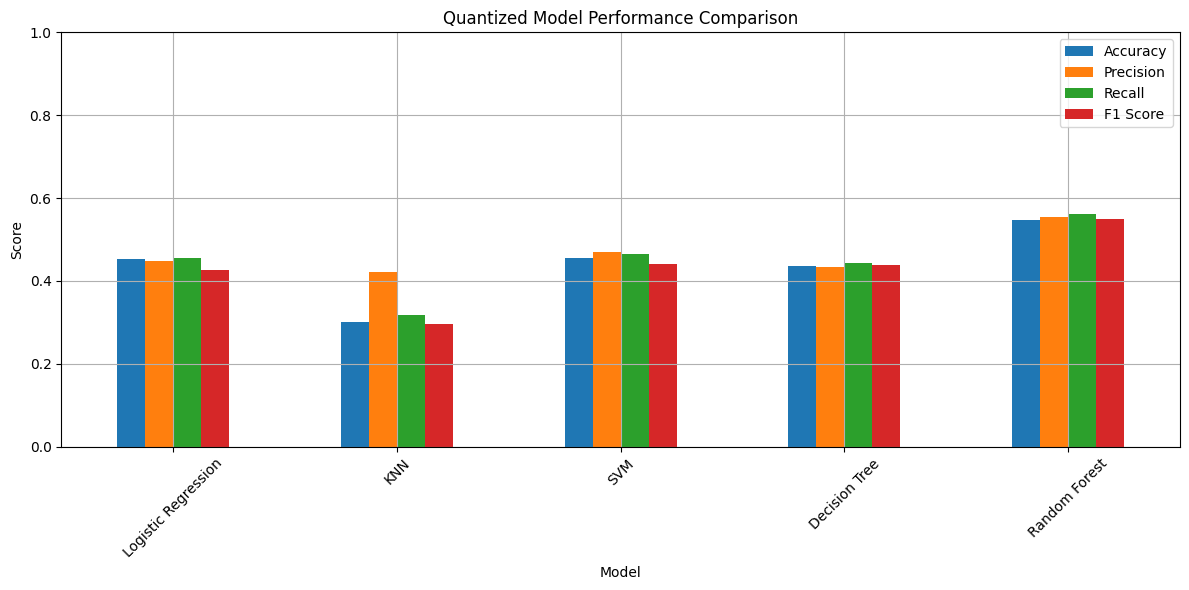

In [30]:

# Data Preparation
# X and y are expected to be raw 8-bit MNIST features and labels

X = features_aug_whitened.astype(np.uint8)  # Already in uint8 format
y = labels_aug

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)







# Manual Quantization-Aware KNN


def train_knn_qaware(X, y):
    
    return X.copy(), y.copy()




def predict_knn_qaware(X_test, X_train, y_train, k=3):
    
    preds = []
    
    for x in X_test:
        
        dists = np.linalg.norm(X_train.astype(np.float32) - x.astype(np.float32), axis=1)
        
        nearest = np.argsort(dists)[:k]
        
        labels = y_train[nearest]
        
        vals, counts = np.unique(labels, return_counts=True)
        
        preds.append(vals[np.argmax(counts)])
        
    return np.array(preds)






# Manual Quantization-Aware Logistic Regression (From Scratch) :

"""

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)


def cross_entropy(y_true, y_pred):
    n = y_true.shape[0]
    y_onehot = np.eye(y_pred.shape[1])[y_true]
    log_preds = -np.log(y_pred + 1e-8)
    return np.sum(y_onehot * log_preds) / n


def train_logistic_regression_qaware(X, y, n_classes, epochs=1000, lr=0.01):
    
    n_samples, n_features = X.shape
    W = np.random.randn(n_classes, n_features).astype(np.float32) * 0.01
    b = np.zeros((n_classes,), dtype=np.float32)

    for epoch in range(epochs):
        
        W_q = np.round((W - W.min()) / (W.max() - W.min() + 1e-6) * 255).astype(np.uint8)
        b_q = np.round((b - b.min()) / (b.max() - b.min() + 1e-6) * 255).astype(np.uint8)
        W_dq = W_q.astype(np.float32) / 255 * (W.max() - W.min() + 1e-6) + W.min()
        b_dq = b_q.astype(np.float32) / 255 * (b.max() - b.min() + 1e-6) + b.min()
        
        logits = np.dot(X.astype(np.float32), W_dq.T) + b_dq
        
        probs = softmax(logits)
        
        loss = cross_entropy(y, probs)
        
        y_onehot = np.eye(n_classes)[y]
        
        grad_logits = (probs - y_onehot) / n_samples
        
        grad_W = np.dot(grad_logits.T, X.astype(np.float32))
        
        grad_b = np.sum(grad_logits, axis=0)
        
        W -= lr * grad_W
        b -= lr * grad_b

        
        if epoch % 10 == 0:
            acc = np.mean(np.argmax(probs, axis=1) == y)
            print(f"Epoch {epoch}, Loss: {loss:.4f}, Accuracy: {acc:.4f}")

    return W_q, W.min(), W.max(), b_q, b.min(), b.max()





def predict_logistic_qaware(X_u8, W_q, b_q, W_min, W_max, b_min, b_max):
    
    W = W_q.astype(np.float32) / 255 * (W_max - W_min + 1e-6) + W_min
    
    b = b_q.astype(np.float32) / 255 * (b_max - b_min + 1e-6) + b_min
    
    logits = np.dot(X_u8.astype(np.float32), W.T) + b
    
    return np.argmax(logits, axis=1)

"""



    
# Manual Quantization-Aware SVM (Linear)

"""

def train_svm_qaware(X, y, n_classes, epochs=1002, lr=0.01):
    
    n_samples, n_features = X.shape
    
    W = np.random.randn(n_classes, n_features).astype(np.float32) * 0.01
    
    b = np.zeros((n_classes,), dtype=np.float32)





    for epoch in range(epochs):
        
        scores = np.dot(X.astype(np.float32), W.T) + b
        
        y_onehot = np.eye(n_classes)[y]
        
        margins = np.maximum(0, scores - scores[np.arange(n_samples), y][:, None] + 1)
        
        margins[np.arange(n_samples), y] = 0
        
        loss = np.sum(margins) / n_samples
        
        coeff_mat = (margins > 0).astype(np.float32)
        
        coeff_mat[np.arange(n_samples), y] -= np.sum(coeff_mat, axis=1)
        
        grad_W = np.dot(coeff_mat.T, X.astype(np.float32)) / n_samples
        
        grad_b = np.sum(coeff_mat, axis=0) / n_samples
        
        W -= lr * grad_W
        b -= lr * grad_b


        
        if epoch % 10 == 0:
            preds = np.argmax(scores, axis=1)
            acc = np.mean(preds == y)
            print(f"[SVM] Epoch {epoch}, Loss: {loss:.4f}, Accuracy: {acc:.4f}")


    
    W_q = np.round((W - W.min()) / (W.max() - W.min() + 1e-6) * 255).astype(np.uint8)
    b_q = np.round((b - b.min()) / (b.max() - b.min() + 1e-6) * 255).astype(np.uint8)
    
    return W_q, W.min(), W.max(), b_q, b.min(), b.max()




def predict_svm_qaware(X_u8, W_q, b_q, W_min, W_max, b_min, b_max):
    
    W = W_q.astype(np.float32) / 255 * (W_max - W_min + 1e-6) + W_min
    b = b_q.astype(np.float32) / 255 * (b_max - b_min + 1e-6) + b_min
    
    scores = np.dot(X_u8.astype(np.float32), W.T) + b
    
    return np.argmax(scores, axis=1)


"""









# Pocket-based Quantization-Aware Logistic Regression (From Scratch)


def softmax(z):
    
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)


    
def cross_entropy(y_true, y_pred):
    
    n = y_true.shape[0]
    y_onehot = np.eye(y_pred.shape[1])[y_true]
    log_preds = -np.log(y_pred + 1e-8)
    return np.sum(y_onehot * log_preds) / n

    
def train_logistic_regression_qaware(X, y, n_classes, epochs=100, lr=0.01):
    
    n_samples, n_features = X.shape
    
    W = np.random.randn(n_classes, n_features).astype(np.float32) * 0.01
    b = np.zeros((n_classes,), dtype=np.float32)

    best_acc = 0
    best_W, best_b = None, None

    
    for epoch in range(epochs):
        
        W_q = np.round((W - W.min()) / (W.max() - W.min() + 1e-6) * 255).astype(np.uint8)
        b_q = np.round((b - b.min()) / (b.max() - b.min() + 1e-6) * 255).astype(np.uint8)
        W_dq = W_q.astype(np.float32) / 255 * (W.max() - W.min() + 1e-6) + W.min()
        b_dq = b_q.astype(np.float32) / 255 * (b.max() - b.min() + 1e-6) + b.min()

        logits = np.dot(X.astype(np.float32), W_dq.T) + b_dq
        probs = softmax(logits)
        loss = cross_entropy(y, probs)

        acc = np.mean(np.argmax(probs, axis=1) == y)
        
        if acc > best_acc:
            best_acc = acc
            best_W, best_b = W.copy(), b.copy()

        y_onehot = np.eye(n_classes)[y]
        grad_logits = (probs - y_onehot) / n_samples
        grad_W = np.dot(grad_logits.T, X.astype(np.float32))
        grad_b = np.sum(grad_logits, axis=0)
        W -= lr * grad_W
        b -= lr * grad_b

        if epoch % 10 == 0:
            print(f"[LR] Epoch {epoch}, Loss: {loss:.4f}, Accuracy: {acc:.4f}")


    
    print(f"\n")
    print(f"\n")


    
    # Use best weights
    
    W = best_W
    b = best_b
    
    W_q = np.round((W - W.min()) / (W.max() - W.min() + 1e-6) * 255).astype(np.uint8)
    b_q = np.round((b - b.min()) / (b.max() - b.min() + 1e-6) * 255).astype(np.uint8)
    return W_q, W.min(), W.max(), b_q, b.min(), b.max()





def predict_logistic_qaware(X_u8, W_q, b_q, W_min, W_max, b_min, b_max):
    
    W = W_q.astype(np.float32) / 255 * (W_max - W_min + 1e-6) + W_min
    b = b_q.astype(np.float32) / 255 * (b_max - b_min + 1e-6) + b_min
    
    logits = np.dot(X_u8.astype(np.float32), W.T) + b
    
    return np.argmax(logits, axis=1)













# Pocket-based Quantization-Aware SVM (Linear)


def train_svm_qaware(X, y, n_classes, epochs=100, lr=0.01):
    
    n_samples, n_features = X.shape
    
    W = np.random.randn(n_classes, n_features).astype(np.float32) * 0.01
    b = np.zeros((n_classes,), dtype=np.float32)

    best_acc = 0
    best_W, best_b = None, None


    
    for epoch in range(epochs):
        
        scores = np.dot(X.astype(np.float32), W.T) + b
        y_onehot = np.eye(n_classes)[y]
        margins = np.maximum(0, scores - scores[np.arange(n_samples), y][:, None] + 1)
        margins[np.arange(n_samples), y] = 0
        loss = np.sum(margins) / n_samples

        acc = np.mean(np.argmax(scores, axis=1) == y)
        if acc > best_acc:
            best_acc = acc
            best_W, best_b = W.copy(), b.copy()

        coeff_mat = (margins > 0).astype(np.float32)
        coeff_mat[np.arange(n_samples), y] -= np.sum(coeff_mat, axis=1)
        grad_W = np.dot(coeff_mat.T, X.astype(np.float32)) / n_samples
        grad_b = np.sum(coeff_mat, axis=0) / n_samples
        W -= lr * grad_W
        b -= lr * grad_b

        if epoch % 10 == 0:
            print(f"[SVM] Epoch {epoch}, Loss: {loss:.4f}, Accuracy: {acc:.4f}")

            
    print(f"\n")
    print(f"\n")


    # Use best weights
    W = best_W
    b = best_b
    W_q = np.round((W - W.min()) / (W.max() - W.min() + 1e-6) * 255).astype(np.uint8)
    b_q = np.round((b - b.min()) / (b.max() - b.min() + 1e-6) * 255).astype(np.uint8)
    return W_q, W.min(), W.max(), b_q, b.min(), b.max()


def predict_svm_qaware(X_u8, W_q, b_q, W_min, W_max, b_min, b_max):
    W = W_q.astype(np.float32) / 255 * (W_max - W_min + 1e-6) + W_min
    b = b_q.astype(np.float32) / 255 * (b_max - b_min + 1e-6) + b_min
    scores = np.dot(X_u8.astype(np.float32), W.T) + b
    return np.argmax(scores, axis=1)









# Manual Quantization-Aware Decision Tree


def train_decision_tree_qaware(X, y, max_depth=25):
    from collections import Counter

    class Node:
        def __init__(self, gini, samples, value, feature_index=None, threshold=None, left=None, right=None):
            self.gini = gini
            self.samples = samples
            self.value = value
            self.feature_index = feature_index
            self.threshold = threshold
            self.left = left
            self.right = right

    
    def gini_impurity(labels): # much more appropriate for mcu rather than entropy function , but we already calculate entropy for curriculum learning ! so future work implement gini index for curriculum learning sample order rather than entropy !!! 
        counts = np.bincount(labels)
        probs = counts / len(labels)
        return 1.0 - np.sum(probs ** 2)

        
    def best_split(X, y):
        m, n = X.shape
        best_idx, best_thr, best_gain = None, None, 0
        parent_gini = gini_impurity(y)
        for idx in range(n):
            thresholds = np.unique(X[:, idx])
            for thr in thresholds:
                left_mask = X[:, idx] <= thr
                right_mask = ~left_mask
                if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
                    continue
                gini_left = gini_impurity(y[left_mask])
                gini_right = gini_impurity(y[right_mask])
                gain = parent_gini - (len(y[left_mask]) * gini_left + len(y[right_mask]) * gini_right) / len(y)
                if gain > best_gain:
                    best_gain = gain
                    best_idx, best_thr = idx, thr
        return best_idx, best_thr


    
    def build_tree(X, y, depth=0):
        num_samples_per_class = [np.sum(y == i) for i in range(np.max(y)+1)]
        predicted_class = np.argmax(num_samples_per_class)
        node = Node(gini=gini_impurity(y), samples=len(y), value=predicted_class)

        if depth < max_depth and len(np.unique(y)) > 1:
            idx, thr = best_split(X, y)
            if idx is not None:
                left_idx = X[:, idx] <= thr
                right_idx = ~left_idx
                node.feature_index = idx
                node.threshold = thr
                node.left = build_tree(X[left_idx], y[left_idx], depth + 1)
                node.right = build_tree(X[right_idx], y[right_idx], depth + 1)
        return node

    return build_tree(X, y)



def predict_decision_tree_qaware(X, tree):
    preds = []
    for x in X:
        node = tree
        while node.left:
            if x[node.feature_index] <= node.threshold:
                node = node.left
            else:
                node = node.right
        preds.append(node.value)
    return np.array(preds)






# Manual Quantization-Aware Random Forest


def train_random_forest_qaware(X, y, n_trees=25, max_depth=25):
    trees = []
    rng = np.random.default_rng(seed=42)
    n_samples = X.shape[0]

    for _ in range(n_trees):
        indices = rng.integers(0, n_samples, n_samples)
        X_sample, y_sample = X[indices], y[indices]
        tree = train_decision_tree_qaware(X_sample, y_sample, max_depth=max_depth)
        trees.append(tree)
    return trees


def predict_random_forest_qaware(X, trees):
    all_preds = []
    for tree in trees:
        preds = predict_decision_tree_qaware(X, tree)
        all_preds.append(preds)
    all_preds = np.array(all_preds).T
    final_preds = []
    for row in all_preds:
        vals, counts = np.unique(row, return_counts=True)
        final_preds.append(vals[np.argmax(counts)])
    return np.array(final_preds)








# Train All Models with MCU constrained parameters !!!


n_classes = len(np.unique(y_train))


W_q_lr, W_min_lr, W_max_lr, b_q_lr, b_min_lr, b_max_lr = train_logistic_regression_qaware(X_train, y_train, n_classes=n_classes, epochs=100, lr=0.01)

X_train_knn, y_train_knn = train_knn_qaware(X_train, y_train)

W_q_svm, W_min_svm, W_max_svm, b_q_svm, b_min_svm, b_max_svm = train_svm_qaware(X_train, y_train, n_classes=n_classes, epochs=100, lr=0.01)

tree_model = train_decision_tree_qaware(X_train, y_train)

forest_models = train_random_forest_qaware(X_train, y_train, n_trees=25, max_depth=15)








# Evaluate All Models


y_pred_lr = predict_logistic_qaware(X_test, W_q_lr, b_q_lr, W_min_lr, W_max_lr, b_min_lr, b_max_lr)

y_pred_knn = predict_knn_qaware(X_test, X_train_knn, y_train_knn, k=3)

y_pred_svm = predict_svm_qaware(X_test, W_q_svm, b_q_svm, W_min_svm, W_max_svm, b_min_svm, b_max_svm)

y_pred_tree = predict_decision_tree_qaware(X_test, tree_model)

y_pred_rf = predict_random_forest_qaware(X_test, forest_models)




print("Quantization-Aware Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))

print("Quantization-Aware KNN Accuracy:", accuracy_score(y_test, y_pred_knn))

print("Quantization-Aware SVM Accuracy:", accuracy_score(y_test, y_pred_svm))

print("Quantization-Aware Decision Tree Accuracy:", accuracy_score(y_test, y_pred_tree))

print("Quantization-Aware Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))









# initial version , problems !

"""

# Model Size Estimation (in KB)



def estimate_model_size_kb(arrays):
    total_bytes = sum(a.nbytes if hasattr(a, 'nbytes') else 0 for a in arrays)
    return total_bytes / 1024




# Extract decision tree arrays directly from tree_model dictionary keys

value_q_dt = tree_model.get('value_q', np.array([]))

threshold_q_dt = tree_model.get('threshold_q', np.array([]))

tree_arrays = [value_q_dt, threshold_q_dt]



# Extract random forest arrays similarly

rf_arrays = []

for model in forest_models:
    
    value_q = model.get('value_q', np.array([]))
    
    threshold_q = model.get('threshold_q', np.array([]))
    
    rf_arrays.extend([value_q, threshold_q])









model_sizes = {
    
    'Logistic Regression': estimate_model_size_kb([W_q_lr, b_q_lr]),
    'KNN': estimate_model_size_kb([X_train_knn]),
    'SVM': estimate_model_size_kb([W_q_svm, b_q_svm]),
    'Decision Tree': estimate_model_size_kb(tree_arrays),
    'Random Forest': estimate_model_size_kb(rf_arrays)
}




print("\nQuantized Model Sizes (KB):")
for k, v in model_sizes.items():
    print(f"{k}: {v:.2f} kB")


"""








# first version not so accurate model size calc for SVM and Log. Res.

"""


# Model Size Estimation (in KB)



def estimate_model_size_kb(arrays):
    
    total_bytes = sum(a.nbytes if hasattr(a, 'nbytes') else 0 for a in arrays)
    return total_bytes / 1024


    
def serialize_tree(node, features=[], thresholds=[], values=[]):
    if node is None:
        return
    if node.left is not None or node.right is not None:
        features.append(node.feature_index if node.feature_index is not None else -1)
        thresholds.append(node.threshold if node.threshold is not None else -1.0)
        values.append(-1)  # Internal node
        serialize_tree(node.left, features, thresholds, values)
        serialize_tree(node.right, features, thresholds, values)
    else:
        features.append(-1)
        thresholds.append(-1.0)
        values.append(node.value)





def quantize_array(arr):
    min_val = min(arr) if len(arr) > 0 else 0
    max_val = max(arr) if len(arr) > 0 else 1
    if max_val == min_val:
        max_val = min_val + 1
    arr = np.array(arr, dtype=np.float32)
    q_arr = ((arr - min_val) / (max_val - min_val) * 255).astype(np.uint8)
    return q_arr, min_val, max_val






# Serialize and quantize decision tree

features_list = []

thresholds_list = []

values_list = []

serialize_tree(tree_model, features_list, thresholds_list, values_list)

features_q, _, _ = quantize_array(features_list)

thresholds_q, _, _ = quantize_array(thresholds_list)

values_q, _, _ = quantize_array(values_list)

dt_size_kb = estimate_model_size_kb([features_q, thresholds_q, values_q])








# Serialize and quantize random forest

rf_total_bytes = 0

for tree in forest_models:
    
    f_list, t_list, v_list = [], [], []
    
    serialize_tree(tree, f_list, t_list, v_list)
    
    f_q, _, _ = quantize_array(f_list)
    
    t_q, _, _ = quantize_array(t_list)
    
    v_q, _, _ = quantize_array(v_list)
    
    rf_total_bytes += f_q.nbytes + t_q.nbytes + v_q.nbytes
    
rf_size_kb = rf_total_bytes / 1024







model_sizes = {
    
    'Logistic Regression': estimate_model_size_kb([W_q_lr, b_q_lr]),
    'KNN': estimate_model_size_kb([X_train_knn]),
    'SVM': estimate_model_size_kb([W_q_svm, b_q_svm]),
    'Decision Tree': dt_size_kb,
    'Random Forest': rf_size_kb
}


print("\nQuantized Model Sizes (KB):")
for k, v in model_sizes.items():
    print(f"{k}: {v:.2f} kB")


"""







# not much changed second vers.

"""


# Model Size Estimation (in KB)


def estimate_model_size_kb(arrays):
    total_bytes = 0
    for a in arrays:
        if hasattr(a, 'nbytes'):
            total_bytes += a.nbytes
        elif isinstance(a, (list, np.ndarray)):
            total_bytes += np.array(a).nbytes
        else:
            try:
                total_bytes += np.array([a]).nbytes
            except:
                pass
    return total_bytes / 1024

def serialize_tree(node, features=[], thresholds=[], values=[]):
    if node is None:
        return
    if node.left is not None or node.right is not None:
        features.append(node.feature_index if node.feature_index is not None else -1)
        thresholds.append(node.threshold if node.threshold is not None else -1.0)
        values.append(-1)  # Internal node
        serialize_tree(node.left, features, thresholds, values)
        serialize_tree(node.right, features, thresholds, values)
    else:
        features.append(-1)
        thresholds.append(-1.0)
        values.append(node.value)

def quantize_array(arr):
    min_val = min(arr) if len(arr) > 0 else 0
    max_val = max(arr) if len(arr) > 0 else 1
    if max_val == min_val:
        max_val = min_val + 1
    arr = np.array(arr, dtype=np.float32)
    q_arr = ((arr - min_val) / (max_val - min_val) * 255).astype(np.uint8)
    return q_arr, min_val, max_val

# Serialize and quantize decision tree
features_list = []
thresholds_list = []
values_list = []
serialize_tree(tree_model, features_list, thresholds_list, values_list)
features_q, _, _ = quantize_array(features_list)
thresholds_q, _, _ = quantize_array(thresholds_list)
values_q, _, _ = quantize_array(values_list)
dt_size_kb = estimate_model_size_kb([features_q, thresholds_q, values_q])

# Serialize and quantize random forest
rf_total_bytes = 0
for tree in forest_models:
    f_list, t_list, v_list = [], [], []
    serialize_tree(tree, f_list, t_list, v_list)
    f_q, _, _ = quantize_array(f_list)
    t_q, _, _ = quantize_array(t_list)
    v_q, _, _ = quantize_array(v_list)
    rf_total_bytes += f_q.nbytes + t_q.nbytes + v_q.nbytes
rf_size_kb = rf_total_bytes / 1024

# Doğru hesaplama için Logistic Regression ve SVM ağırlıklarının toplam byte sayısı:
lr_size_kb = (W_q_lr.nbytes + b_q_lr.nbytes) / 1024
svm_size_kb = (W_q_svm.nbytes + b_q_svm.nbytes) / 1024

model_sizes = {
    'Logistic Regression': lr_size_kb,
    'KNN': estimate_model_size_kb([X_train_knn]),
    'SVM': svm_size_kb,
    'Decision Tree': dt_size_kb,
    'Random Forest': rf_size_kb
}

print("\nQuantized Model Sizes (KB):")
for model_name, size in model_sizes.items():
    print(f"{model_name}: {size:.2f} kB")


"""







# version 3 complete !

# Model Size Estimation (in KB)



def estimate_model_size_kb(arrays):

    total_bytes = 0
    
    for a in arrays:
        if hasattr(a, 'nbytes'):
            total_bytes += a.nbytes
        elif isinstance(a, (list, np.ndarray)):
            total_bytes += np.array(a).nbytes
        else:
            try:
                total_bytes += np.array([a]).nbytes
            except:
                pass
    return total_bytes / 1024




def serialize_tree(node, features=[], thresholds=[], values=[]):
    
    if node is None:
        return
        
    if node.left is not None or node.right is not None:
        
        features.append(node.feature_index if node.feature_index is not None else -1)
        thresholds.append(node.threshold if node.threshold is not None else -1.0)
        values.append(-1)  # Internal node
        serialize_tree(node.left, features, thresholds, values)
        serialize_tree(node.right, features, thresholds, values)
        
    else:
        features.append(-1)
        thresholds.append(-1.0)
        values.append(node.value)



        
def quantize_array(arr):
    
    min_val = min(arr) if len(arr) > 0 else 0
    max_val = max(arr) if len(arr) > 0 else 1
    
    if max_val == min_val:
        max_val = min_val + 1
        
    arr = np.array(arr, dtype=np.float32)
    
    q_arr = ((arr - min_val) / (max_val - min_val) * 255).astype(np.uint8)
    
    return q_arr, min_val, max_val





# Serialize and quantize decision tree

features_list = []

thresholds_list = []

values_list = []

serialize_tree(tree_model, features_list, thresholds_list, values_list)

features_q, _, _ = quantize_array(features_list)

thresholds_q, _, _ = quantize_array(thresholds_list)

values_q, _, _ = quantize_array(values_list)

dt_size_kb = estimate_model_size_kb([features_q, thresholds_q, values_q])




# Serialize and quantize random forest

rf_total_bytes = 0

for tree in forest_models:
    
    f_list, t_list, v_list = [], [], []
    
    serialize_tree(tree, f_list, t_list, v_list)
    
    f_q, _, _ = quantize_array(f_list)
    
    t_q, _, _ = quantize_array(t_list)
    
    v_q, _, _ = quantize_array(v_list)
    
    rf_total_bytes += f_q.nbytes + t_q.nbytes + v_q.nbytes
    
rf_size_kb = rf_total_bytes / 1024




# for SVM and Logistic Regression detailed print

print("\n\n Logistic Regression W_q_lr shape:", W_q_lr.shape, "bytes:", W_q_lr.nbytes)

print("Logistic Regression b_q_lr shape:", b_q_lr.shape, "bytes:", b_q_lr.nbytes)

print("Total Logistic Regression size (kB):", (W_q_lr.nbytes + b_q_lr.nbytes) / 1024)



print("\n\n SVM W_q_svm shape:", W_q_svm.shape, "bytes:", W_q_svm.nbytes)

print("SVM b_q_svm shape:", b_q_svm.shape, "bytes:", b_q_svm.nbytes)

print("Total SVM size (kB):", (W_q_svm.nbytes + b_q_svm.nbytes) / 1024)




lr_size_kb = (W_q_lr.nbytes + b_q_lr.nbytes) / 1024

svm_size_kb = (W_q_svm.nbytes + b_q_svm.nbytes) / 1024






model_sizes = {
    
    'Logistic Regression': lr_size_kb,
    'KNN': estimate_model_size_kb([X_train_knn]),
    'SVM': svm_size_kb,
    'Decision Tree': dt_size_kb,
    'Random Forest': rf_size_kb
}




print("\nQuantized Model Sizes (KB):")
for model_name, size in model_sizes.items():
    print(f"{model_name}: {size:.2f} kB")











# Metrics Visualization


metrics = {
    
    'Model': ['Logistic Regression', 'KNN', 'SVM', 'Decision Tree', 'Random Forest'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_knn),
        accuracy_score(y_test, y_pred_svm),
        accuracy_score(y_test, y_pred_tree),
        accuracy_score(y_test, y_pred_rf)
    ],
    'Precision': [
        precision_score(y_test, y_pred_lr, average='macro', zero_division=0),
        precision_score(y_test, y_pred_knn, average='macro', zero_division=0),
        precision_score(y_test, y_pred_svm, average='macro', zero_division=0),
        precision_score(y_test, y_pred_tree, average='macro', zero_division=0),
        precision_score(y_test, y_pred_rf, average='macro', zero_division=0)
    ],
    'Recall': [
        recall_score(y_test, y_pred_lr, average='macro', zero_division=0),
        recall_score(y_test, y_pred_knn, average='macro', zero_division=0),
        recall_score(y_test, y_pred_svm, average='macro', zero_division=0),
        recall_score(y_test, y_pred_tree, average='macro', zero_division=0),
        recall_score(y_test, y_pred_rf, average='macro', zero_division=0)
    ],
    'F1 Score': [
        f1_score(y_test, y_pred_lr, average='macro', zero_division=0),
        f1_score(y_test, y_pred_knn, average='macro', zero_division=0),
        f1_score(y_test, y_pred_svm, average='macro', zero_division=0),
        f1_score(y_test, y_pred_tree, average='macro', zero_division=0),
        f1_score(y_test, y_pred_rf, average='macro', zero_division=0)
    ]
}




metrics_df = pd.DataFrame(metrics)
metrics_df.set_index('Model', inplace=True)


metrics_df.plot(kind='bar', figsize=(12, 6))

plt.title('Quantized Model Performance Comparison')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



# Now test on full mnist test dataset with full data augmentation (10000 to 20000 augmented samples)



 After applied Pseudo-ERF : 10000 number of image data  with 784 number of features.


 After applied Data augmentation : 20000 number of samples.


 Applied Whitening to PCA features.


[LR] Epoch 0, Loss: 12.3631, Accuracy: 0.0919
[LR] Epoch 10, Loss: 12.0075, Accuracy: 0.3254
[LR] Epoch 20, Loss: 10.9157, Accuracy: 0.3759
[LR] Epoch 30, Loss: 10.1231, Accuracy: 0.4118
[LR] Epoch 40, Loss: 9.7516, Accuracy: 0.4318
[LR] Epoch 50, Loss: 11.3441, Accuracy: 0.3539
[LR] Epoch 60, Loss: 9.8066, Accuracy: 0.4316
[LR] Epoch 70, Loss: 10.5705, Accuracy: 0.3956
[LR] Epoch 80, Loss: 9.5223, Accuracy: 0.4497
[LR] Epoch 90, Loss: 10.6864, Accuracy: 0.3896




[SVM-Poly] Epoch 0, Loss: 35962.8438, Accuracy: 0.0952
[SVM-Poly] Epoch 10, Loss: 15643979.0000, Accuracy: 0.6666
[SVM-Poly] Epoch 20, Loss: 2329039.2500, Accuracy: 0.8279
[SVM-Poly] Epoch 30, Loss: 774349.0625, Accuracy: 0.8921
[SVM-Poly] Epoch 40, Loss: 318798.2188, Accuracy: 0.9358
[SVM-Poly] Epoch 50, Loss: 160625.5625, Accuracy: 0.949

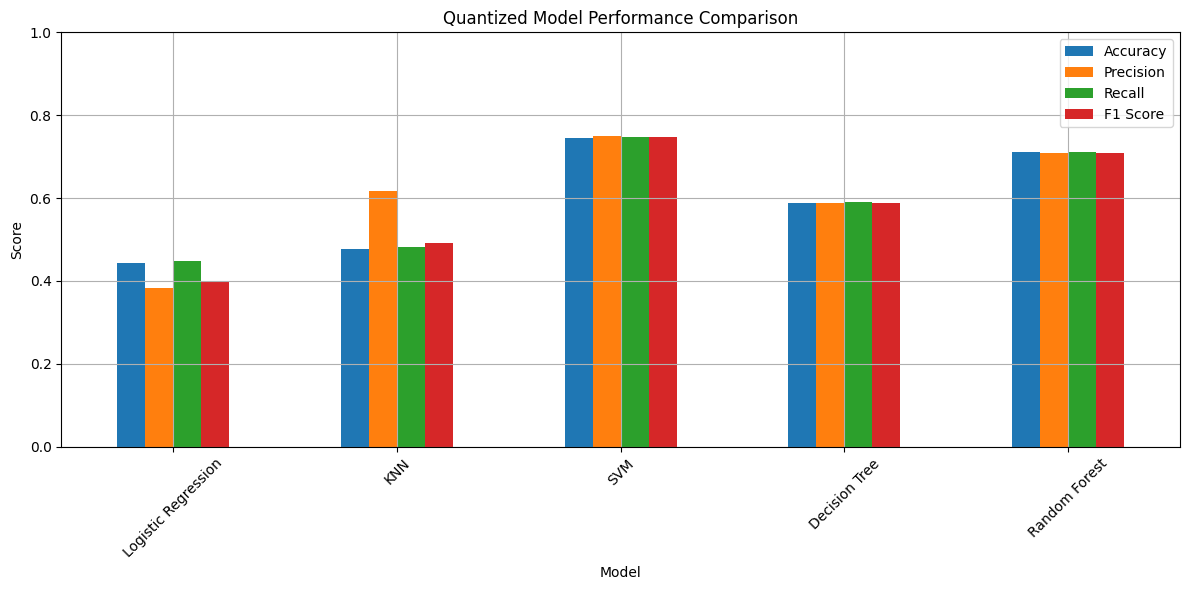

In [31]:


# Load Fashion-MNIST dataset again

transform = transforms.Compose([
    transforms.Resize((28, 28)), 
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.squeeze())
])


dataset = datasets.MNIST(root='./', train=True, download=True, transform=transform)

images = []
labels = []

for img, label in dataset:
    img_array = (img.numpy() * 255).astype('uint8').flatten()
    images.append(img_array)
    labels.append(label)
    
images = np.array(images)
labels = np.array(labels)




# Filter low-quality samples (variance and brightness)

variances = np.var(images, axis=1)
variance_threshold = np.percentile(variances, 1)
mean_brightness = np.mean(images, axis=1)
brightness_lower = 5
brightness_upper = 250


valid_indices = (variances > variance_threshold) & (mean_brightness > brightness_lower) & (mean_brightness < brightness_upper)

images = images[valid_indices]
labels = labels[valid_indices]






# Select balanced samples

n_samples = 10000
samples_per_class = n_samples // 10

selected_images = []
selected_labels = []

for digit in range(10):
    digit_indices = [i for i, label in enumerate(labels) if label == digit]
    selected_indices = digit_indices[:samples_per_class]
    selected_images.extend([images[i] for i in selected_indices])
    selected_labels.extend([labels[i] for i in selected_indices])

    
images = np.array(selected_images)
labels = np.array(selected_labels)





# Apply pseudo-ERF (just add Gaussian blur ; not exactly ERF)

def apply_erf(images, image_size=(28,28), sigma=0.5):
    
    processed = []
    
    for img in images:
        
        img_reshaped = img.reshape(image_size).astype(float)
        img_erf = gaussian_filter(img_reshaped, sigma=sigma)
        processed.append(img_erf.flatten())
        
    return np.array(processed, dtype=images.dtype)



images_erf = apply_erf(images)


print(f"\n\n After applied Pseudo-ERF : {len(images_erf)} number of image data  with {images_erf[0].size} number of features.") 













"""

# Data augmentation ( just random shift and rotation)

def augment_data(images, labels, image_size=(28,28), augment_factor=1):

    
    augmented_images = list(images)
    augmented_labels = list(labels)
    
    n = len(images)
    
    for i in range(n):
        
        img = images[i].reshape(image_size)
        #img = images_erf[i]
        
        label = labels[i]
        
        for _ in range(augment_factor):
            
            shift_x = np.random.uniform(-2, 2)
            
            shift_y = np.random.uniform(-2, 2)
            
            shifted = shift(img, shift=(shift_x, shift_y), mode='nearest')
            
            angle = np.random.uniform(-15, 15)
            
            rotated = rotate(shifted, angle, reshape=False, mode='nearest')
            
            augmented_images.append(rotated.flatten())
            
            augmented_labels.append(label)
            
    return np.array(augmented_images), np.array(augmented_labels)

images_aug, labels_aug = augment_data(images_erf, labels, augment_factor=1)


print(f"\n\n After applied Data augmentation : {len(images_aug)} number of samples.") 

"""







# full data augmentation for real world scenarios !!!

def augment_data(images, labels, image_size=(28, 28), augment_factor=1):


    augmented_images = list(images)  # Start with original images
    augmented_labels = list(labels)
    
    n = len(images)

    
    for i in range(n):
        
        img = images[i].reshape(image_size).astype(np.float32)  # Reshape to 2D image
        
        label = labels[i]

        for _ in range(augment_factor):
            
            aug_img = img.copy()

            # 1) Random shift (translation)
            
            shift_x = np.random.uniform(-2, 2)  # shift range in pixels horizontally
            shift_y = np.random.uniform(-2, 2)  # shift range in pixels vertically
            
            aug_img = shift(aug_img, shift=(shift_x, shift_y), mode='nearest')


            
            # 2) Random rotation
            angle = np.random.uniform(-15, 15)  # rotate between -15 and +15 degrees
            aug_img = rotate(aug_img, angle, reshape=False, mode='nearest')



            
            # 3) Random scaling (zoom)
            scale_factor = np.random.uniform(0.9, 1.1)  # zoom between 90% and 110%

            
            # Zoom with center crop or padding to maintain image size
            zoomed_img = zoom(aug_img, zoom=scale_factor)

            
            zh, zw = zoomed_img.shape
            ih, iw = image_size


            
            if scale_factor < 1.0:
                
                # Pad zoomed image to original size
                
                pad_h1 = (ih - zh) // 2
                pad_h2 = ih - zh - pad_h1
                pad_w1 = (iw - zw) // 2
                pad_w2 = iw - zw - pad_w1
                aug_img = np.pad(zoomed_img, ((pad_h1, pad_h2), (pad_w1, pad_w2)), mode='constant', constant_values=0)
                
            else:
                # Crop zoomed image to original size
                start_h = (zh - ih) // 2
                start_w = (zw - iw) // 2
                aug_img = zoomed_img[start_h:start_h+ih, start_w:start_w+iw]



            
            # 4) Random cropping + padding

            crop_ratio = np.random.uniform(0.85, 1.0)  # Crop between 85% and 100% of original size
            ch, cw = int(crop_ratio * ih), int(crop_ratio * iw)
            start_crop_h = np.random.randint(0, ih - ch + 1)
            start_crop_w = np.random.randint(0, iw - cw + 1)
            cropped_img = aug_img[start_crop_h:start_crop_h+ch, start_crop_w:start_crop_w+cw]

            
            
            # Pad back to original size
            
            pad_h1 = start_crop_h
            pad_h2 = ih - ch - pad_h1
            pad_w1 = start_crop_w
            pad_w2 = iw - cw - pad_w1
            aug_img = np.pad(cropped_img, ((pad_h1, pad_h2), (pad_w1, pad_w2)), mode='constant', constant_values=0)



            
            # 5) Add Gaussian noise
            
            noise_sigma = np.random.uniform(0, 10)  # noise sigma from 0 to 10 intensity
            noise = np.random.normal(0, noise_sigma, size=aug_img.shape)
            aug_img = aug_img + noise
            aug_img = np.clip(aug_img, 0, 255)  # Clip pixel values to valid range


            

            # Flatten augmented image and add to dataset
            
            augmented_images.append(aug_img.flatten().astype(np.uint8))
            augmented_labels.append(label)

    
    return np.array(augmented_images), np.array(augmented_labels)






images_aug, labels_aug = augment_data(images_erf, labels, augment_factor=1)


print(f"\n\n After applied Data augmentation : {len(images_aug)} number of samples.") 








# Feature extraction and whitening (SVD+PCA+Whitening) on augmented ERF image data 

normalized_aug = images_aug / 255.0

svd_aug = TruncatedSVD(n_components=784, random_state=42)

features_aug = svd_aug.fit_transform(normalized_aug)

scaler_aug = StandardScaler()

pca_aug = PCA(n_components=0.95, random_state=42) # 183 feature

features_aug_pca = pca_aug.fit_transform(features_aug)

features_aug_whitened = scaler_aug.fit_transform(features_aug_pca)


print(f"\n\n Applied Whitening to PCA features.\n\n")    
#print(f"\n\n Applied Whitening to {len(features_aug_pca)} number of features.")    





# Train/test split
#X_train_aug, X_test_aug, y_train_aug, y_test_aug = train_test_split(features_aug_whitened, labels_aug, test_size=0.2, random_state=42, stratify=labels_aug)



# Data Preparation
# X and y are expected to be raw 8-bit MNIST features and labels


X = features_aug_whitened.astype(np.uint8)  # Already in uint8 format
y = labels_aug

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)





# Entropy-based ordering (ascending for curriculum learning)

entropies = []

for img in X_train:
    hist, _ = np.histogram(img, bins=256, range=(0, 256))
    hist = hist / np.sum(hist)
    img_entropy = entropy(hist + 1e-10)
    entropies.append(img_entropy)
    
entropies = np.array(entropies)
sorted_indices = np.argsort(entropies)

X_train = X_train[sorted_indices]
y_train = y_train[sorted_indices]






# Manual Quantization-Aware KNN


def train_knn_qaware(X, y):
    return X.copy(), y.copy()

def predict_knn_qaware(X_test, X_train, y_train, k=3): # minimal k parameter for mcu
    preds = []
    for x in X_test:
        dists = np.linalg.norm(X_train.astype(np.float32) - x.astype(np.float32), axis=1)
        nearest = np.argsort(dists)[:k]
        labels = y_train[nearest]
        vals, counts = np.unique(labels, return_counts=True)
        preds.append(vals[np.argmax(counts)])
    return np.array(preds)









# Manual Quantization-Aware Logistic Regression (From Scratch) :

"""

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def cross_entropy(y_true, y_pred):
    n = y_true.shape[0]
    y_onehot = np.eye(y_pred.shape[1])[y_true]
    log_preds = -np.log(y_pred + 1e-8)
    return np.sum(y_onehot * log_preds) / n

def train_logistic_regression_qaware(X, y, n_classes, epochs=1000, lr=0.01):
    n_samples, n_features = X.shape
    W = np.random.randn(n_classes, n_features).astype(np.float32) * 0.01
    b = np.zeros((n_classes,), dtype=np.float32)

    for epoch in range(epochs):
        W_q = np.round((W - W.min()) / (W.max() - W.min() + 1e-6) * 255).astype(np.uint8)
        b_q = np.round((b - b.min()) / (b.max() - b.min() + 1e-6) * 255).astype(np.uint8)
        W_dq = W_q.astype(np.float32) / 255 * (W.max() - W.min() + 1e-6) + W.min()
        b_dq = b_q.astype(np.float32) / 255 * (b.max() - b.min() + 1e-6) + b.min()
        logits = np.dot(X.astype(np.float32), W_dq.T) + b_dq
        probs = softmax(logits)
        loss = cross_entropy(y, probs)
        y_onehot = np.eye(n_classes)[y]
        grad_logits = (probs - y_onehot) / n_samples
        grad_W = np.dot(grad_logits.T, X.astype(np.float32))
        grad_b = np.sum(grad_logits, axis=0)
        W -= lr * grad_W
        b -= lr * grad_b
        if epoch % 10 == 0:
            acc = np.mean(np.argmax(probs, axis=1) == y)
            print(f"Epoch {epoch}, Loss: {loss:.4f}, Accuracy: {acc:.4f}")

            
    print(f"\n")
    
    return W_q, W.min(), W.max(), b_q, b.min(), b.max()


def predict_logistic_qaware(X_u8, W_q, b_q, W_min, W_max, b_min, b_max):
    W = W_q.astype(np.float32) / 255 * (W_max - W_min + 1e-6) + W_min
    b = b_q.astype(np.float32) / 255 * (b_max - b_min + 1e-6) + b_min
    logits = np.dot(X_u8.astype(np.float32), W.T) + b
    return np.argmax(logits, axis=1)


"""






# Manual Quantization-Aware SVM (Linear only)

"""

def train_svm_qaware(X, y, n_classes, epochs=1002, lr=0.01):
    n_samples, n_features = X.shape
    W = np.random.randn(n_classes, n_features).astype(np.float32) * 0.01
    b = np.zeros((n_classes,), dtype=np.float32)

    for epoch in range(epochs):
        scores = np.dot(X.astype(np.float32), W.T) + b
        y_onehot = np.eye(n_classes)[y]
        margins = np.maximum(0, scores - scores[np.arange(n_samples), y][:, None] + 1)
        margins[np.arange(n_samples), y] = 0
        loss = np.sum(margins) / n_samples
        coeff_mat = (margins > 0).astype(np.float32)
        coeff_mat[np.arange(n_samples), y] -= np.sum(coeff_mat, axis=1)
        grad_W = np.dot(coeff_mat.T, X.astype(np.float32)) / n_samples
        grad_b = np.sum(coeff_mat, axis=0) / n_samples
        W -= lr * grad_W
        b -= lr * grad_b
        if epoch % 10 == 0:
            preds = np.argmax(scores, axis=1)
            acc = np.mean(preds == y)
            print(f"[SVM] Epoch {epoch}, Loss: {loss:.4f}, Accuracy: {acc:.4f}")
            
    print(f"\n")
    
    W_q = np.round((W - W.min()) / (W.max() - W.min() + 1e-6) * 255).astype(np.uint8)
    b_q = np.round((b - b.min()) / (b.max() - b.min() + 1e-6) * 255).astype(np.uint8)
    
    return W_q, W.min(), W.max(), b_q, b.min(), b.max()





def predict_svm_qaware(X_u8, W_q, b_q, W_min, W_max, b_min, b_max):
    
    W = W_q.astype(np.float32) / 255 * (W_max - W_min + 1e-6) + W_min
    
    b = b_q.astype(np.float32) / 255 * (b_max - b_min + 1e-6) + b_min
    
    scores = np.dot(X_u8.astype(np.float32), W.T) + b
    
    return np.argmax(scores, axis=1)

"""







"""

# Pocket-based Quantization-Aware Logistic Regression (From Scratch)


def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def cross_entropy(y_true, y_pred):
    n = y_true.shape[0]
    y_onehot = np.eye(y_pred.shape[1])[y_true]
    log_preds = -np.log(y_pred + 1e-8)
    return np.sum(y_onehot * log_preds) / n

def train_logistic_regression_qaware(X, y, n_classes, epochs=100, lr=0.01):
    n_samples, n_features = X.shape
    W = np.random.randn(n_classes, n_features).astype(np.float32) * 0.01
    b = np.zeros((n_classes,), dtype=np.float32)

    best_acc = 0
    best_W, best_b = None, None

    for epoch in range(epochs):
        W_q = np.round((W - W.min()) / (W.max() - W.min() + 1e-6) * 255).astype(np.uint8)
        b_q = np.round((b - b.min()) / (b.max() - b.min() + 1e-6) * 255).astype(np.uint8)
        W_dq = W_q.astype(np.float32) / 255 * (W.max() - W.min() + 1e-6) + W.min()
        b_dq = b_q.astype(np.float32) / 255 * (b.max() - b.min() + 1e-6) + b.min()

        logits = np.dot(X.astype(np.float32), W_dq.T) + b_dq
        probs = softmax(logits)
        loss = cross_entropy(y, probs)

        acc = np.mean(np.argmax(probs, axis=1) == y)
        if acc > best_acc:
            best_acc = acc
            best_W, best_b = W.copy(), b.copy()

        y_onehot = np.eye(n_classes)[y]
        grad_logits = (probs - y_onehot) / n_samples
        grad_W = np.dot(grad_logits.T, X.astype(np.float32))
        grad_b = np.sum(grad_logits, axis=0)
        W -= lr * grad_W
        b -= lr * grad_b

        if epoch % 10 == 0:
            print(f"[LR] Epoch {epoch}, Loss: {loss:.4f}, Accuracy: {acc:.4f}")

            
    print(f"\n")
    print(f"\n")



    
    # Use best weights
    W = best_W
    b = best_b
    W_q = np.round((W - W.min()) / (W.max() - W.min() + 1e-6) * 255).astype(np.uint8)
    b_q = np.round((b - b.min()) / (b.max() - b.min() + 1e-6) * 255).astype(np.uint8)
    return W_q, W.min(), W.max(), b_q, b.min(), b.max()



def predict_logistic_qaware(X_u8, W_q, b_q, W_min, W_max, b_min, b_max):
    W = W_q.astype(np.float32) / 255 * (W_max - W_min + 1e-6) + W_min
    b = b_q.astype(np.float32) / 255 * (b_max - b_min + 1e-6) + b_min
    logits = np.dot(X_u8.astype(np.float32), W.T) + b
    return np.argmax(logits, axis=1)











# Pocket-based Quantization-Aware SVM (Linear)


def train_svm_qaware(X, y, n_classes, epochs=100, lr=0.01):
    n_samples, n_features = X.shape
    W = np.random.randn(n_classes, n_features).astype(np.float32) * 0.01
    b = np.zeros((n_classes,), dtype=np.float32)

    best_acc = 0
    best_W, best_b = None, None

    for epoch in range(epochs):
        scores = np.dot(X.astype(np.float32), W.T) + b
        y_onehot = np.eye(n_classes)[y]
        margins = np.maximum(0, scores - scores[np.arange(n_samples), y][:, None] + 1)
        margins[np.arange(n_samples), y] = 0
        loss = np.sum(margins) / n_samples

        acc = np.mean(np.argmax(scores, axis=1) == y)
        if acc > best_acc:
            best_acc = acc
            best_W, best_b = W.copy(), b.copy()

        coeff_mat = (margins > 0).astype(np.float32)
        coeff_mat[np.arange(n_samples), y] -= np.sum(coeff_mat, axis=1)
        grad_W = np.dot(coeff_mat.T, X.astype(np.float32)) / n_samples
        grad_b = np.sum(coeff_mat, axis=0) / n_samples
        W -= lr * grad_W
        b -= lr * grad_b

        if epoch % 10 == 0:
            print(f"[SVM] Epoch {epoch}, Loss: {loss:.4f}, Accuracy: {acc:.4f}")

            
    print(f"\n")
    print(f"\n")




    
    # Use best weights
    W = best_W
    b = best_b
    W_q = np.round((W - W.min()) / (W.max() - W.min() + 1e-6) * 255).astype(np.uint8)
    b_q = np.round((b - b.min()) / (b.max() - b.min() + 1e-6) * 255).astype(np.uint8)
    return W_q, W.min(), W.max(), b_q, b.min(), b.max()



def predict_svm_qaware(X_u8, W_q, b_q, W_min, W_max, b_min, b_max):
    W = W_q.astype(np.float32) / 255 * (W_max - W_min + 1e-6) + W_min
    b = b_q.astype(np.float32) / 255 * (b_max - b_min + 1e-6) + b_min
    scores = np.dot(X_u8.astype(np.float32), W.T) + b
    return np.argmax(scores, axis=1)


"""





# Pocket-based Quantization-Aware Logistic Regression (8-bit or 16-bit)



def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)




def cross_entropy(y_true, y_pred):
    n = y_true.shape[0]
    y_onehot = np.eye(y_pred.shape[1])[y_true]
    log_preds = -np.log(y_pred + 1e-8)
    return np.sum(y_onehot * log_preds) / n






def train_logistic_regression_qaware(X, y, n_classes, epochs=100, lr=0.01, bits=8):

    assert bits in (8, 16), "Only 8-bit and 16-bit quantization are supported."
    
    scale = (2 ** bits) - 1

    n_samples, n_features = X.shape
    W = np.random.randn(n_classes, n_features).astype(np.float32) * 0.01
    b = np.zeros((n_classes,), dtype=np.float32)

    best_acc = 0
    best_W, best_b = None, None

    
    for epoch in range(epochs):
        
        W_q = np.round((W - W.min()) / (W.max() - W.min() + 1e-6) * scale).astype(f'uint{bits}')
        b_q = np.round((b - b.min()) / (b.max() - b.min() + 1e-6) * scale).astype(f'uint{bits}')
        W_dq = W_q.astype(np.float32) / scale * (W.max() - W.min() + 1e-6) + W.min()
        b_dq = b_q.astype(np.float32) / scale * (b.max() - b.min() + 1e-6) + b.min()

        logits = np.dot(X.astype(np.float32), W_dq.T) + b_dq
        probs = softmax(logits)
        loss = cross_entropy(y, probs)

        acc = np.mean(np.argmax(probs, axis=1) == y)

        
        if acc > best_acc:
            
            best_acc = acc
            best_W, best_b = W.copy(), b.copy()

        y_onehot = np.eye(n_classes)[y]
        
        grad_logits = (probs - y_onehot) / n_samples
        
        grad_W = np.dot(grad_logits.T, X.astype(np.float32))
        grad_b = np.sum(grad_logits, axis=0)
        
        W -= lr * grad_W
        b -= lr * grad_b


        
        if epoch % 10 == 0:
            
            print(f"[LR] Epoch {epoch}, Loss: {loss:.4f}, Accuracy: {acc:.4f}")


    print(f"\n")
    print(f"\n")
    
    
    W = best_W
    b = best_b
    
    W_q = np.round((W - W.min()) / (W.max() - W.min() + 1e-6) * scale).astype(f'uint{bits}')
    b_q = np.round((b - b.min()) / (b.max() - b.min() + 1e-6) * scale).astype(f'uint{bits}')
    
    return W_q, W.min(), W.max(), b_q, b.min(), b.max(), bits





def predict_logistic_qaware(X_u8, W_q, b_q, W_min, W_max, b_min, b_max, bits=8):
    
    scale = (2 ** bits) - 1
    
    W = W_q.astype(np.float32) / scale * (W_max - W_min + 1e-6) + W_min
    b = b_q.astype(np.float32) / scale * (b_max - b_min + 1e-6) + b_min
    
    logits = np.dot(X_u8.astype(np.float32), W.T) + b
    
    return np.argmax(logits, axis=1)





def predict_logistic_qaware_integer(X_u8, W_q, b_q, bits=8):
    
    W = W_q.astype(np.int16)
    b = b_q.astype(np.int16)
    
    scores = np.dot(X_u8.astype(np.int32), W.T) + b
    
    return np.argmax(scores, axis=1)









"""

# Pocket-based Quantization-Aware SVM (Polynomial Kernel + 8/16-bit)


def polynomial_kernel(X, W, degree=2): # more like nonlinear activation function , use polynomial expansion instead of this function !!!
    
    return (np.dot(X, W.T) + 1) ** degree




def train_svm_qaware(X, y, n_classes, epochs=1000, lr=0.01, degree=2, bits=8):
    
    assert 1 <= degree <= 5, "Polynomial kernel degree must be between 1 and 5." # analytical solution boundary
    assert bits in (8, 16), "Only 8-bit and 16-bit quantization are supported."
    
    scale = (2 ** bits) - 1

    n_samples, n_features = X.shape
    
    W = np.random.randn(n_classes, n_features).astype(np.float32) * 0.01
    b = np.zeros((n_classes,), dtype=np.float32)

    best_acc = 0
    best_W, best_b = None, None


    
    for epoch in range(epochs):
        
        scores = polynomial_kernel(X.astype(np.float32), W, degree) + b
        
        y_onehot = np.eye(n_classes)[y]
        
        margins = np.maximum(0, scores - scores[np.arange(n_samples), y][:, None] + 1)
        
        margins[np.arange(n_samples), y] = 0
        
        loss = np.sum(margins) / n_samples

        acc = np.mean(np.argmax(scores, axis=1) == y)
        
        if acc > best_acc:
            best_acc = acc
            best_W, best_b = W.copy(), b.copy()

        coeff_mat = (margins > 0).astype(np.float32)
        coeff_mat[np.arange(n_samples), y] -= np.sum(coeff_mat, axis=1)
        
        grad_W = np.dot(coeff_mat.T, X.astype(np.float32)) / n_samples
        grad_b = np.sum(coeff_mat, axis=0) / n_samples
        
        W -= lr * grad_W
        b -= lr * grad_b



        
        if epoch % 10 == 0:
            
            print(f"[SVM-Poly] Epoch {epoch}, Loss: {loss:.4f}, Accuracy: {acc:.4f}")


    
    print(f"\n")
    print(f"\n")

    
    W = best_W
    b = best_b
    
    W_q = np.round((W - W.min()) / (W.max() - W.min() + 1e-6) * scale).astype(f'uint{bits}')
    b_q = np.round((b - b.min()) / (b.max() - b.min() + 1e-6) * scale).astype(f'uint{bits}')
    
    return W_q, W.min(), W.max(), b_q, b.min(), b.max(), degree, bits
    





def predict_svm_qaware(X_u8, W_q, b_q, W_min, W_max, b_min, b_max, degree=2, bits=8):
    
    scale = (2 ** bits) - 1
    
    W = W_q.astype(np.float32) / scale * (W_max - W_min + 1e-6) + W_min
    
    b = b_q.astype(np.float32) / scale * (b_max - b_min + 1e-6) + b_min
    
    scores = polynomial_kernel(X_u8.astype(np.float32), W, degree) + b
    
    return np.argmax(scores, axis=1)





def predict_svm_qaware_integer(X_u8, W_q, b_q, degree=2, bits=8):
    
    W = W_q.astype(np.int32)
    
    b = b_q.astype(np.int32)
    
    scores = ((np.dot(X_u8.astype(np.int32), W.T) + 1) ** degree) + b
    
    return np.argmax(scores, axis=1)



"""


    




# Manual Polynomial Feature Expansion SVM (Optional Replacement for Kernel)

def manual_polynomial_features(X, degree=2):
    
    assert 1 <= degree <= 5, "Polynomial feature degree must be 1 to 5"
    
    n_samples, n_features = X.shape
    
    combinations = list(combinations_with_replacement(range(n_features), degree))
    
    expanded = np.empty((n_samples, len(combinations)), dtype=X.dtype)

    for i, comb in enumerate(combinations):
        expanded[:, i] = np.prod(X[:, comb], axis=1)

    return expanded



# Pocket-based Quantization-Aware SVM (Manual Polynomial Expansion + 8/16-bit)


def train_svm_qaware(X, y, n_classes, epochs=100, lr=0.01, degree=2, bits=16):
    
    assert 1 <= degree <= 5, "Polynomial kernel degree must be between 1 and 5."
    
    assert bits in (8, 16), "Only 8-bit and 16-bit quantization are supported."
    
    scale = (2 ** bits) - 1

    X_poly = manual_polynomial_features(X.astype(np.float32), degree)
    
    n_samples, n_features = X_poly.shape
    
    W = np.random.randn(n_classes, n_features).astype(np.float32) * 0.01
    
    b = np.zeros((n_classes,), dtype=np.float32)

    best_acc = 0
    best_W, best_b = None, None


    
    for epoch in range(epochs):
        
        scores = np.dot(X_poly, W.T) + b
        
        y_onehot = np.eye(n_classes)[y]
        
        margins = np.maximum(0, scores - scores[np.arange(n_samples), y][:, None] + 1)
        
        margins[np.arange(n_samples), y] = 0
        
        loss = np.sum(margins) / n_samples

        acc = np.mean(np.argmax(scores, axis=1) == y)
        
        if acc > best_acc:
            best_acc = acc
            best_W, best_b = W.copy(), b.copy()

        
        coeff_mat = (margins > 0).astype(np.float32)
        
        coeff_mat[np.arange(n_samples), y] -= np.sum(coeff_mat, axis=1)
        
        grad_W = np.dot(coeff_mat.T, X_poly) / n_samples
        
        grad_b = np.sum(coeff_mat, axis=0) / n_samples
        
        W -= lr * grad_W
        b -= lr * grad_b

        
        if epoch % 10 == 0:
            print(f"[SVM-Poly] Epoch {epoch}, Loss: {loss:.4f}, Accuracy: {acc:.4f}")

            
    print(f"\n")
    print(f"\n")


    W = best_W
    b = best_b
    
    W_q = np.round((W - W.min()) / (W.max() - W.min() + 1e-6) * scale).astype(f'uint{bits}')
    b_q = np.round((b - b.min()) / (b.max() - b.min() + 1e-6) * scale).astype(f'uint{bits}')
    
    return W_q, W.min(), W.max(), b_q, b.min(), b.max(), degree, bits





def predict_svm_qaware(X_u8, W_q, b_q, W_min, W_max, b_min, b_max, degree=2, bits=16):
    
    scale = (2 ** bits) - 1
    
    X_poly = manual_polynomial_features(X_u8.astype(np.float32), degree)
    
    W = W_q.astype(np.float32) / scale * (W_max - W_min + 1e-6) + W_min
    b = b_q.astype(np.float32) / scale * (b_max - b_min + 1e-6) + b_min
    
    scores = np.dot(X_poly, W.T) + b
    
    return np.argmax(scores, axis=1)




def predict_svm_qaware_integer(X_u8, W_q, b_q, degree=2, bits=16):
    
    X_poly = manual_polynomial_features(X_u8.astype(np.int16), degree)
    
    W = W_q.astype(np.int16)
    b = b_q.astype(np.int16)
    
    scores = np.dot(X_poly, W.T) + b
    
    return np.argmax(scores, axis=1)









# Manual Quantization-Aware Decision Tree


def train_decision_tree_qaware(X, y, max_depth=25):
    
    

    class Node:
        
        def __init__(self, gini, samples, value, feature_index=None, threshold=None, left=None, right=None):
            
            self.gini = gini
            self.samples = samples
            self.value = value
            self.feature_index = feature_index
            self.threshold = threshold
            self.left = left
            self.right = right




    
    
    def gini_impurity(labels): # use entropy in future developments
        
        counts = np.bincount(labels)
        
        probs = counts / len(labels)
        
        return 1.0 - np.sum(probs ** 2)






        
    def best_split(X, y):
        
        m, n = X.shape
        
        best_idx, best_thr, best_gain = None, None, 0
        
        parent_gini = gini_impurity(y)
        
        for idx in range(n):
            
            thresholds = np.unique(X[:, idx])
            
            for thr in thresholds:
                
                left_mask = X[:, idx] <= thr
                
                right_mask = ~left_mask
                
                if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
                    
                    continue
                gini_left = gini_impurity(y[left_mask])
                
                gini_right = gini_impurity(y[right_mask])
                
                gain = parent_gini - (len(y[left_mask]) * gini_left + len(y[right_mask]) * gini_right) / len(y)
                
                if gain > best_gain:
                    best_gain = gain
                    best_idx, best_thr = idx, thr
                    
        return best_idx, best_thr





    
    
    def build_tree(X, y, depth=0):
        
        num_samples_per_class = [np.sum(y == i) for i in range(np.max(y)+1)]
        
        predicted_class = np.argmax(num_samples_per_class)
        
        node = Node(gini=gini_impurity(y), samples=len(y), value=predicted_class)

        if depth < max_depth and len(np.unique(y)) > 1:
            idx, thr = best_split(X, y)
            
            if idx is not None:
                
                left_idx = X[:, idx] <= thr
                right_idx = ~left_idx
                node.feature_index = idx
                node.threshold = thr
                node.left = build_tree(X[left_idx], y[left_idx], depth + 1)
                node.right = build_tree(X[right_idx], y[right_idx], depth + 1)
                
        return node

    return build_tree(X, y)





def predict_decision_tree_qaware(X, tree):
    
    preds = []
    
    for x in X:
        node = tree
        while node.left:
            if x[node.feature_index] <= node.threshold:
                node = node.left
            else:
                node = node.right
                
        preds.append(node.value)
        
    return np.array(preds)









# Manual Quantization-Aware Random Forest


def train_random_forest_qaware(X, y, n_trees=25, max_depth=25):
    
    trees = []
    
    rng = np.random.default_rng(seed=42)
    
    n_samples = X.shape[0]


    
    for _ in range(n_trees):
        
        indices = rng.integers(0, n_samples, n_samples)
        X_sample, y_sample = X[indices], y[indices]
        tree = train_decision_tree_qaware(X_sample, y_sample, max_depth=max_depth)
        trees.append(tree)
        
    return trees




def predict_random_forest_qaware(X, trees):
    
    all_preds = []
    
    for tree in trees:
        
        preds = predict_decision_tree_qaware(X, tree)
        
        all_preds.append(preds)
        
    all_preds = np.array(all_preds).T
    
    final_preds = []
    
    for row in all_preds:
        
        vals, counts = np.unique(row, return_counts=True)
        final_preds.append(vals[np.argmax(counts)])
        
    return np.array(final_preds)








# Train All Models (simulate as if in the MCU ; so very small parameters have to be choose !!!)

"""

n_classes = len(np.unique(y_train))


W_q_lr, W_min_lr, W_max_lr, b_q_lr, b_min_lr, b_max_lr = train_logistic_regression_qaware(X_train, y_train, n_classes=n_classes, epochs=100, lr=0.005)

X_train_knn, y_train_knn = train_knn_qaware(X_train, y_train)

W_q_svm, W_min_svm, W_max_svm, b_q_svm, b_min_svm, b_max_svm = train_svm_qaware(X_train, y_train, n_classes=n_classes, epochs=100, lr=0.005)

tree_model = train_decision_tree_qaware(X_train, y_train)

forest_models = train_random_forest_qaware(X_train, y_train, n_trees=50, max_depth=10)

"""






# Train All Models with time (when simulate as if in the MCU ; small parameters have to be choose !!!)


n_classes = len(np.unique(y_train))

start_time = time.time()
W_q_lr, W_min_lr, W_max_lr, b_q_lr, b_min_lr, b_max_lr , bits_res_lr = train_logistic_regression_qaware(X_train, y_train, n_classes=n_classes, epochs=100, lr=0.01 , bits=16)
time_lr = time.time() - start_time

start_time = time.time()
X_train_knn, y_train_knn = train_knn_qaware(X_train, y_train)
time_knn = time.time() - start_time

start_time = time.time()
W_q_svm, W_min_svm, W_max_svm, b_q_svm, b_min_svm, b_max_svm , deg_of_svm , bits_res_svm = train_svm_qaware(X_train, y_train, n_classes=n_classes, epochs=100, lr=0.01 , degree=2, bits=16)
time_svm = time.time() - start_time

start_time = time.time()
tree_model = train_decision_tree_qaware(X_train, y_train)
time_tree = time.time() - start_time

start_time = time.time()
forest_models = train_random_forest_qaware(X_train, y_train, n_trees=25, max_depth=20)
time_rf = time.time() - start_time







# Evaluate All Models


y_pred_lr = predict_logistic_qaware(X_test, W_q_lr, b_q_lr, W_min_lr, W_max_lr, b_min_lr, b_max_lr , bits_res_lr)

y_pred_knn = predict_knn_qaware(X_test, X_train_knn, y_train_knn, k=5) # k=3 for simplest config. for MCU and max k = 9 !

y_pred_svm = predict_svm_qaware(X_test, W_q_svm, b_q_svm, W_min_svm, W_max_svm, b_min_svm, b_max_svm, deg_of_svm, bits_res_svm)

y_pred_tree = predict_decision_tree_qaware(X_test, tree_model)

y_pred_rf = predict_random_forest_qaware(X_test, forest_models)




print("\n Quantization-Aware Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))

print("\n Quantization-Aware KNN Accuracy:", accuracy_score(y_test, y_pred_knn))

print("\n Quantization-Aware SVM Accuracy:", accuracy_score(y_test, y_pred_svm))

print("\n Quantization-Aware Decision Tree Accuracy:", accuracy_score(y_test, y_pred_tree))

print("\n Quantization-Aware Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))


print(f"\n")
print(f"\n")






# version 3 complete !

# Model Size Estimation (in KB)

"""

def estimate_model_size_kb(arrays):

    total_bytes = 0
    
    for a in arrays:
        if hasattr(a, 'nbytes'):
            total_bytes += a.nbytes
        elif isinstance(a, (list, np.ndarray)):
            total_bytes += np.array(a).nbytes
        else:
            try:
                total_bytes += np.array([a]).nbytes
            except:
                pass
    return total_bytes / 1024




def serialize_tree(node, features=[], thresholds=[], values=[]):
    
    if node is None:
        return
        
    if node.left is not None or node.right is not None:
        
        features.append(node.feature_index if node.feature_index is not None else -1)
        thresholds.append(node.threshold if node.threshold is not None else -1.0)
        values.append(-1)  # Internal node
        serialize_tree(node.left, features, thresholds, values)
        serialize_tree(node.right, features, thresholds, values)
        
    else:
        features.append(-1)
        thresholds.append(-1.0)
        values.append(node.value)



        
def quantize_array(arr):
    
    min_val = min(arr) if len(arr) > 0 else 0
    max_val = max(arr) if len(arr) > 0 else 1
    
    if max_val == min_val:
        max_val = min_val + 1
        
    arr = np.array(arr, dtype=np.float32)
    
    q_arr = ((arr - min_val) / (max_val - min_val) * 255).astype(np.uint8)
    
    return q_arr, min_val, max_val





# Serialize and quantize decision tree

features_list = []

thresholds_list = []

values_list = []

serialize_tree(tree_model, features_list, thresholds_list, values_list)

features_q, _, _ = quantize_array(features_list)

thresholds_q, _, _ = quantize_array(thresholds_list)

values_q, _, _ = quantize_array(values_list)

dt_size_kb = estimate_model_size_kb([features_q, thresholds_q, values_q])




# Serialize and quantize random forest

rf_total_bytes = 0

for tree in forest_models:
    
    f_list, t_list, v_list = [], [], []
    
    serialize_tree(tree, f_list, t_list, v_list)
    
    f_q, _, _ = quantize_array(f_list)
    
    t_q, _, _ = quantize_array(t_list)
    
    v_q, _, _ = quantize_array(v_list)
    
    rf_total_bytes += f_q.nbytes + t_q.nbytes + v_q.nbytes
    
rf_size_kb = rf_total_bytes / 1024




# for SVM and Logistic Regression detailed print

print("\n\n Logistic Regression W_q_lr shape:", W_q_lr.shape, "bytes:", W_q_lr.nbytes)

print("Logistic Regression b_q_lr shape:", b_q_lr.shape, "bytes:", b_q_lr.nbytes)

print("Total Logistic Regression size (kB):", (W_q_lr.nbytes + b_q_lr.nbytes) / 1024)



print("\n\n SVM W_q_svm shape:", W_q_svm.shape, "bytes:", W_q_svm.nbytes)

print("SVM b_q_svm shape:", b_q_svm.shape, "bytes:", b_q_svm.nbytes)

print("Total SVM size (kB):", (W_q_svm.nbytes + b_q_svm.nbytes) / 1024)




lr_size_kb = (W_q_lr.nbytes + b_q_lr.nbytes) / 1024

svm_size_kb = (W_q_svm.nbytes + b_q_svm.nbytes) / 1024






model_sizes = {
    
    'Logistic Regression': lr_size_kb,
    'KNN': estimate_model_size_kb([X_train_knn]),
    'SVM': svm_size_kb,
    'Decision Tree': dt_size_kb,
    'Random Forest': rf_size_kb
}




print("\nQuantized Model Sizes (KB):")
for model_name, size in model_sizes.items():
    print(f"{model_name}: {size:.2f} kB")


"""






# Model Size Estimation (in KB) and SRAM Usage



def estimate_model_size_kb(arrays):
    
    total_bytes = sum(a.nbytes if hasattr(a, 'nbytes') else 0 for a in arrays)
    return total_bytes / 1024




def serialize_tree(node, features=[], thresholds=[], values=[]):
    
    if node is None:
        return
    if node.left is not None or node.right is not None:
        features.append(node.feature_index if node.feature_index is not None else -1)
        thresholds.append(node.threshold if node.threshold is not None else -1.0)
        values.append(-1)  # Internal node
        serialize_tree(node.left, features, thresholds, values)
        serialize_tree(node.right, features, thresholds, values)
    else:
        features.append(-1)
        thresholds.append(-1.0)
        values.append(node.value)



def quantize_array(arr):
    
    min_val = min(arr) if len(arr) > 0 else 0
    max_val = max(arr) if len(arr) > 0 else 1
    if max_val == min_val:
        max_val = min_val + 1
    arr = np.array(arr, dtype=np.float32)
    q_arr = ((arr - min_val) / (max_val - min_val) * 255).astype(np.uint8)
    return q_arr, min_val, max_val







# Serialize and quantize decision tree

features_list = []

thresholds_list = []

values_list = []

serialize_tree(tree_model, features_list, thresholds_list, values_list)

features_q, _, _ = quantize_array(features_list)

thresholds_q, _, _ = quantize_array(thresholds_list)

values_q, _, _ = quantize_array(values_list)

dt_size_kb = estimate_model_size_kb([features_q, thresholds_q, values_q])

dt_sram_kb = estimate_model_size_kb([np.array(features_list), np.array(thresholds_list), np.array(values_list)])








# Serialize and quantize random forest

rf_total_bytes = 0
rf_sram_bytes = 0

for tree in forest_models:
    
    f_list, t_list, v_list = [], [], []
    
    serialize_tree(tree, f_list, t_list, v_list)
    
    f_q, _, _ = quantize_array(f_list)
    
    t_q, _, _ = quantize_array(t_list)
    
    v_q, _, _ = quantize_array(v_list)
    
    rf_total_bytes += f_q.nbytes + t_q.nbytes + v_q.nbytes
    
    rf_sram_bytes += np.array(f_list).nbytes + np.array(t_list).nbytes + np.array(v_list).nbytes

    
rf_size_kb = rf_total_bytes / 1024
rf_sram_kb = rf_sram_bytes / 1024








model_sizes = {
    
    'Logistic Regression': estimate_model_size_kb([W_q_lr, b_q_lr]),
    'KNN': estimate_model_size_kb([X_train_knn]),
    'SVM': estimate_model_size_kb([W_q_svm, b_q_svm]),
    'Decision Tree': dt_size_kb,
    'Random Forest': rf_size_kb
}

model_sram = {
    
    'Logistic Regression': estimate_model_size_kb([W_q_lr, b_q_lr]),
    'KNN': estimate_model_size_kb([X_train_knn]),
    'SVM': estimate_model_size_kb([W_q_svm, b_q_svm]),
    'Decision Tree': dt_sram_kb,
    'Random Forest': rf_sram_kb
}

model_times = {
    
    'Logistic Regression': time_lr,
    'KNN': time_knn,
    'SVM': time_svm,
    'Decision Tree': time_tree,
    'Random Forest': time_rf
}










# Platform Comparison Table

platforms = {
    
    "Tiny MCU (28KB ROM / 1.8KB SRAM)": (28, 1.8),
    "Mid MCU (200KB ROM / 4KB SRAM)": (200, 4) ,
    "Dev. MCU (400KB ROM / 48KB SRAM)": (200, 4)
}





print("\nQuantized Model Sizes (KB):")

for platform_name, (rom_limit, sram_limit) in platforms.items():
    
    print(f"\n--- {platform_name} ---")
    
    for model in model_sizes:
        
        rom = model_sizes[model]
        sram = model_sram[model]
        time_sec = model_times[model]
        rom_ok = "OK" if rom <= rom_limit else "OVER"
        sram_ok = "OK" if sram <= sram_limit else "OVER"
        
        print(f"{model:18s} | ROM: {rom:6.2f} kB ({rom_ok}) | SRAM: {sram:5.2f} kB ({sram_ok}) | Time: {time_sec:5.2f} sec")



print(f"\n")
print(f"\n")







# Metrics Visualization


metrics = {
    
    'Model': ['Logistic Regression', 'KNN', 'SVM', 'Decision Tree', 'Random Forest'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_knn),
        accuracy_score(y_test, y_pred_svm),
        accuracy_score(y_test, y_pred_tree),
        accuracy_score(y_test, y_pred_rf)
    ],
    'Precision': [
        precision_score(y_test, y_pred_lr, average='macro', zero_division=0),
        precision_score(y_test, y_pred_knn, average='macro', zero_division=0),
        precision_score(y_test, y_pred_svm, average='macro', zero_division=0),
        precision_score(y_test, y_pred_tree, average='macro', zero_division=0),
        precision_score(y_test, y_pred_rf, average='macro', zero_division=0)
    ],
    'Recall': [
        recall_score(y_test, y_pred_lr, average='macro', zero_division=0),
        recall_score(y_test, y_pred_knn, average='macro', zero_division=0),
        recall_score(y_test, y_pred_svm, average='macro', zero_division=0),
        recall_score(y_test, y_pred_tree, average='macro', zero_division=0),
        recall_score(y_test, y_pred_rf, average='macro', zero_division=0)
    ],
    'F1 Score': [
        f1_score(y_test, y_pred_lr, average='macro', zero_division=0),
        f1_score(y_test, y_pred_knn, average='macro', zero_division=0),
        f1_score(y_test, y_pred_svm, average='macro', zero_division=0),
        f1_score(y_test, y_pred_tree, average='macro', zero_division=0),
        f1_score(y_test, y_pred_rf, average='macro', zero_division=0)
    ]
}




metrics_df = pd.DataFrame(metrics)
metrics_df.set_index('Model', inplace=True)


metrics_df.plot(kind='bar', figsize=(12, 6))

plt.title('Quantized Model Performance Comparison')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# SIMPLIFIED LAST VERSION (BUT NOW WE WILL USE 18X18 CMOS PIXEL GRAB DATA SIZE INSTEAD OF 28X28)



 After applied Pseudo-ERF : 10000 number of image data  with 324 number of features.


 After applied Data augmentation : 20000 number of samples.


 Applied Whitening to PCA features.


[LogReg] Epoch 0, Loss: 10.5783, Accuracy: 0.0841
[LogReg] Epoch 10, Loss: 11.6491, Accuracy: 0.3109
[LogReg] Epoch 20, Loss: 12.5600, Accuracy: 0.2739
[LogReg] Epoch 30, Loss: 10.5758, Accuracy: 0.3581
[LogReg] Epoch 40, Loss: 11.2816, Accuracy: 0.3241
[LogReg] Epoch 50, Loss: 10.8728, Accuracy: 0.3581
[LogReg] Epoch 60, Loss: 10.6570, Accuracy: 0.3529
[LogReg] Epoch 70, Loss: 10.7360, Accuracy: 0.3697
[LogReg] Epoch 80, Loss: 11.0972, Accuracy: 0.3429
[LogReg] Epoch 90, Loss: 11.6712, Accuracy: 0.3096
[LogReg] Epoch 100, Loss: 11.4801, Accuracy: 0.3216
[LogReg] Epoch 110, Loss: 10.6518, Accuracy: 0.3642
[LogReg] Epoch 120, Loss: 10.9647, Accuracy: 0.3461
[LogReg] Epoch 130, Loss: 11.6234, Accuracy: 0.3224
[LogReg] Epoch 140, Loss: 11.1703, Accuracy: 0.3468
[LogReg] Epoch 150, Loss: 12.9686, Accurac

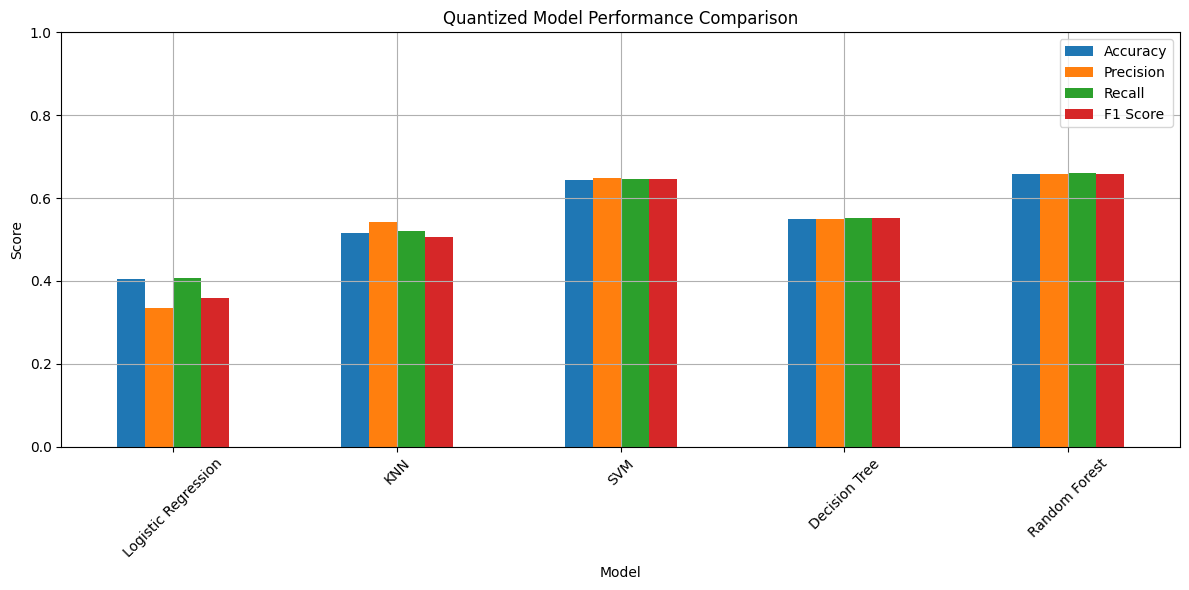

In [33]:


# ORIGINAL SIMPLIFIED CODE


# Load Fashion-MNIST dataset again

transform = transforms.Compose([
    transforms.Resize((18, 18)), 
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.squeeze())
])


dataset = datasets.MNIST(root='./', train=True, download=True, transform=transform)

images = []
labels = []

for img, label in dataset:
    img_array = (img.numpy() * 255).astype('uint8').flatten()
    images.append(img_array)
    labels.append(label)
    
images = np.array(images)
labels = np.array(labels)




# Filter low-quality samples (variance and brightness)

variances = np.var(images, axis=1)
variance_threshold = np.percentile(variances, 1)
mean_brightness = np.mean(images, axis=1)
brightness_lower = 5
brightness_upper = 250


valid_indices = (variances > variance_threshold) & (mean_brightness > brightness_lower) & (mean_brightness < brightness_upper)

images = images[valid_indices]
labels = labels[valid_indices]






# Select balanced samples

n_samples = 10000
samples_per_class = n_samples // 10

selected_images = []
selected_labels = []

for digit in range(10):
    digit_indices = [i for i, label in enumerate(labels) if label == digit]
    selected_indices = digit_indices[:samples_per_class]
    selected_images.extend([images[i] for i in selected_indices])
    selected_labels.extend([labels[i] for i in selected_indices])

    
images = np.array(selected_images)
labels = np.array(selected_labels)





# Apply pseudo-ERF (just add Gaussian blur ; not exactly ERF)

def apply_erf(images, image_size=(18,18), sigma=0.5):
    
    processed = []
    
    for img in images:
        
        img_reshaped = img.reshape(image_size).astype(float)
        img_erf = gaussian_filter(img_reshaped, sigma=sigma)
        processed.append(img_erf.flatten())
        
    return np.array(processed, dtype=images.dtype)



images_erf = apply_erf(images)


print(f"\n\n After applied Pseudo-ERF : {len(images_erf)} number of image data  with {images_erf[0].size} number of features.") 







# full data augmentation for real world scenarios !!!

def augment_data(images_erf, labels, image_size=(18,18), augment_factor=1):


    augmented_images = list(images_erf)  # Start with ERF images
    augmented_labels = list(labels)
    
    n = len(images)

    
    for i in range(n):
        
        img = images[i].reshape(image_size).astype(np.float32)  # Reshape to 2D image
        
        label = labels[i]

        for _ in range(augment_factor):
            
            aug_img = img.copy()

            # 1) Random shift (translation)
            
            shift_x = np.random.uniform(-2, 2)  # shift range in pixels horizontally
            shift_y = np.random.uniform(-2, 2)  # shift range in pixels vertically
            
            aug_img = shift(aug_img, shift=(shift_x, shift_y), mode='nearest')


            
            # 2) Random rotation
            angle = np.random.uniform(-15, 15)  # rotate between -15 and +15 degrees
            aug_img = rotate(aug_img, angle, reshape=False, mode='nearest')



            
            # 3) Random scaling (zoom)
            scale_factor = np.random.uniform(0.9, 1.1)  # zoom between 90% and 110%

            
            # Zoom with center crop or padding to maintain image size
            zoomed_img = zoom(aug_img, zoom=scale_factor)

            
            zh, zw = zoomed_img.shape
            ih, iw = image_size


            
            if scale_factor < 1.0:
                
                # Pad zoomed image to original size
                
                pad_h1 = (ih - zh) // 2
                pad_h2 = ih - zh - pad_h1
                pad_w1 = (iw - zw) // 2
                pad_w2 = iw - zw - pad_w1
                aug_img = np.pad(zoomed_img, ((pad_h1, pad_h2), (pad_w1, pad_w2)), mode='constant', constant_values=0)
                
            else:
                # Crop zoomed image to original size
                start_h = (zh - ih) // 2
                start_w = (zw - iw) // 2
                aug_img = zoomed_img[start_h:start_h+ih, start_w:start_w+iw]



            
            # 4) Random cropping + padding

            crop_ratio = np.random.uniform(0.85, 1.0)  # Crop between 85% and 100% of original size
            ch, cw = int(crop_ratio * ih), int(crop_ratio * iw)
            start_crop_h = np.random.randint(0, ih - ch + 1)
            start_crop_w = np.random.randint(0, iw - cw + 1)
            cropped_img = aug_img[start_crop_h:start_crop_h+ch, start_crop_w:start_crop_w+cw]

            
            
            # Pad back to original size
            
            pad_h1 = start_crop_h
            pad_h2 = ih - ch - pad_h1
            pad_w1 = start_crop_w
            pad_w2 = iw - cw - pad_w1
            aug_img = np.pad(cropped_img, ((pad_h1, pad_h2), (pad_w1, pad_w2)), mode='constant', constant_values=0)



            
            # 5) Add Gaussian noise
            
            noise_sigma = np.random.uniform(0, 10)  # noise sigma from 0 to 10 intensity
            noise = np.random.normal(0, noise_sigma, size=aug_img.shape)
            aug_img = aug_img + noise
            aug_img = np.clip(aug_img, 0, 255)  # Clip pixel values to valid range


            

            # Flatten augmented image and add to dataset
            
            augmented_images.append(aug_img.flatten().astype(np.uint8))
            augmented_labels.append(label)

    
    return np.array(augmented_images), np.array(augmented_labels)






images_aug, labels_aug = augment_data(images_erf, labels, augment_factor=1)


print(f"\n\n After applied Data augmentation : {len(images_aug)} number of samples.") 








# Feature extraction and whitening (SVD+PCA+Whitening) on augmented ERF image data 

normalized_aug = images_aug / 255.0

svd_aug = TruncatedSVD(n_components=324, random_state=42)

features_aug = svd_aug.fit_transform(normalized_aug)

scaler_aug = StandardScaler()

pca_aug = PCA(n_components=0.95, random_state=42) # 183 feature

features_aug_pca = pca_aug.fit_transform(features_aug)

features_aug_whitened = scaler_aug.fit_transform(features_aug_pca)


print(f"\n\n Applied Whitening to PCA features.\n\n")    
#print(f"\n\n Applied Whitening to {len(features_aug_pca)} number of features.")    




# Data Preparation
# X and y are expected to be raw 8-bit MNIST features and labels


X = features_aug_whitened.astype(np.uint8)  # Already in uint8 format
y = labels_aug


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)





# Entropy-based ordering (ascending for curriculum learning)

entropies = []

for img in X_train:
    hist, _ = np.histogram(img, bins=256, range=(0, 256))
    hist = hist / np.sum(hist)
    img_entropy = entropy(hist + 1e-10)
    entropies.append(img_entropy)
    
entropies = np.array(entropies)
sorted_indices = np.argsort(entropies)

X_train = X_train[sorted_indices]
y_train = y_train[sorted_indices]






# Not Quantization-Aware and not efficient KNN (after PCA+Feature Whitening , so not necessary for z-score or min-max normalisation)
# developments will be made in future works...

def train_knn_qaware(X, y):
    
    return X.copy(), y.copy()

def predict_knn_qaware(X_test, X_train, y_train, k=3): # minimal k parameter for mcu
    
    preds = []
    
    for x in X_test:
        
        dists = np.linalg.norm(X_train.astype(np.float32) - x.astype(np.float32), axis=1)
        
        nearest = np.argsort(dists)[:k]
        
        labels = y_train[nearest]
        
        vals, counts = np.unique(labels, return_counts=True)
        
        preds.append(vals[np.argmax(counts)])
        
    return np.array(preds)











# Quantization-Aware Logistic Regression (16-bit default)



def softmax(z):
    
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)



def cross_entropy(y_true, y_pred):
    
    n = y_true.shape[0]
    
    y_onehot = np.eye(y_pred.shape[1])[y_true]
    
    log_preds = -np.log(y_pred + 1e-8)
    
    return np.sum(y_onehot * log_preds) / n





def train_logistic_regression_qaware(X, y, n_classes, epochs=100, lr=0.01, bits=16):

    
    assert bits in (8, 16), "Only 8-bit and 16-bit quantization are supported."

    scale = (2 ** bits) - 1
    
    n_samples, n_features = X.shape

    W = np.random.randn(n_classes, n_features).astype(np.float32) * 0.01
    b = np.zeros((n_classes,), dtype=np.float32)

    best_acc = 0
    best_W, best_b = None, None

    
    for epoch in range(epochs):
        
        logits = np.dot(X.astype(np.float32), W.T) + b
        probs = softmax(logits)
        loss = cross_entropy(y, probs)
        acc = np.mean(np.argmax(probs, axis=1) == y)

        
        if acc > best_acc:
            best_acc = acc
            best_W, best_b = W.copy(), b.copy()

        
        y_onehot = np.eye(n_classes)[y]
        grad_logits = (probs - y_onehot) / n_samples
        grad_W = np.dot(grad_logits.T, X.astype(np.float32))
        grad_b = np.sum(grad_logits, axis=0)

        W -= lr * grad_W
        b -= lr * grad_b

        if epoch % 10 == 0:
            print(f"[LogReg] Epoch {epoch}, Loss: {loss:.4f}, Accuracy: {acc:.4f}")


    
    print(f"\n")
    print(f"\n")


    W = best_W
    b = best_b

    W_q = np.round((W - W.min()) / (W.max() - W.min() + 1e-6) * scale).astype(np.uint16)
    b_q = np.round((b - b.min()) / (b.max() - b.min() + 1e-6) * scale).astype(np.uint16)

    return W_q, W.min(), W.max(), b_q, b.min(), b.max(), bits






def predict_logistic_qaware(X_u8, W_q, b_q, W_min, W_max, b_min, b_max, bits=16):
    
    scale = (2 ** bits) - 1
    
    W = W_q.astype(np.float32) / scale * (W_max - W_min + 1e-6) + W_min
    b = b_q.astype(np.float32) / scale * (b_max - b_min + 1e-6) + b_min
    
    logits = np.dot(X_u8.astype(np.float32), W.T) + b
    
    return np.argmax(logits, axis=1)




def predict_logistic_qaware_integer(X_u8, W_q, b_q, bits=16):
    
    W = W_q.astype(np.int16)
    b = b_q.astype(np.int16)
    
    scores = np.dot(X_u8.astype(np.int16), W.T) + b
    
    return np.argmax(scores, axis=1)








 #Manual Polynomial Feature Expansion (Optional Replacement for Kernel)

def manual_polynomial_features(X, degree=2):
 
    assert 1 <= degree <= 5, "Polynomial feature degree must be 1 to 5"
    
    n_samples, n_features = X.shape
    
    combinations = list(combinations_with_replacement(range(n_features), degree))
    
    expanded = np.empty((n_samples, len(combinations)), dtype=X.dtype)

    for i, comb in enumerate(combinations):
        
        expanded[:, i] = np.prod(X[:, comb], axis=1)

    return expanded






# Quantization-Aware SVM (Manual Polynomial Expansion + 16-bit default)


def train_svm_qaware(X, y, n_classes, epochs=100, lr=0.01, degree=2, bits=16):
    
    assert 1 <= degree <= 5, "Polynomial kernel degree must be between 1 and 5."
    
    assert bits in (8, 16), "Only 8-bit and 16-bit quantization are supported."

    scale = (2 ** bits) - 1
    
    X_poly = manual_polynomial_features(X.astype(np.float32), degree)
    
    n_samples, n_features = X_poly.shape

    W = np.random.randn(n_classes, n_features).astype(np.float32) * 0.01
    b = np.zeros((n_classes,), dtype=np.float32)

    best_acc = 0
    best_W, best_b = None, None


    
    for epoch in range(epochs):
        
        # Forward pass
        scores = np.dot(X_poly, W.T) + b


        
        # Multi-class hinge loss (SVM)
        y_onehot = np.eye(n_classes)[y]
        
        margins = np.maximum(0, scores - scores[np.arange(n_samples), y][:, None] + 1)
        margins[np.arange(n_samples), y] = 0
        
        loss = np.sum(margins) / n_samples


        
        # Accuracy evaluation
        acc = np.mean(np.argmax(scores, axis=1) == y)
        
        if acc > best_acc:
            best_acc = acc
            best_W, best_b = W.copy(), b.copy()


        
        # Gradient calculation
        coeff_mat = (margins > 0).astype(np.float32)
        coeff_mat[np.arange(n_samples), y] -= np.sum(coeff_mat, axis=1)
        
        grad_W = np.dot(coeff_mat.T, X_poly) / n_samples
        grad_b = np.sum(coeff_mat, axis=0) / n_samples


        
        # Update
        W -= lr * grad_W
        b -= lr * grad_b

        if epoch % 10 == 0:
            print(f"[SVM-Poly] Epoch {epoch}, Loss: {loss:.4f}, Accuracy: {acc:.4f}")


    
    print(f"\n")
    print(f"\n")




    
    # Quantize the best weights
    
    W = best_W
    b = best_b
    
    W_q = np.round((W - W.min()) / (W.max() - W.min() + 1e-6) * scale).astype(np.uint16)
    b_q = np.round((b - b.min()) / (b.max() - b.min() + 1e-6) * scale).astype(np.uint16)

    return W_q, W.min(), W.max(), b_q, b.min(), b.max(), degree, bits









# Prediction (Quantized Polynomial SVM - Floating-point decoding)


def predict_svm_qaware(X_u8, W_q, b_q, W_min, W_max, b_min, b_max, degree=2, bits=16):
    
    scale = (2 ** bits) - 1
    
    X_poly = manual_polynomial_features(X_u8.astype(np.float32), degree)
    
    W = W_q.astype(np.float32) / scale * (W_max - W_min + 1e-6) + W_min
    b = b_q.astype(np.float32) / scale * (b_max - b_min + 1e-6) + b_min
    
    scores = np.dot(X_poly, W.T) + b
    
    return np.argmax(scores, axis=1)






# Integer-only prediction version (no float decoding)


def predict_svm_qaware_integer(X_u8, W_q, b_q, degree=2, bits=16):
    
    X_poly = manual_polynomial_features(X_u8.astype(np.int16), degree)
    
    W = W_q.astype(np.int16)
    b = b_q.astype(np.int16)
    
    scores = np.dot(X_poly, W.T) + b
    
    return np.argmax(scores, axis=1)
















# Manual Quantization-Aware Decision Tree


def train_decision_tree_qaware(X, y, max_depth=25):
    
    

    class Node:
        
        def __init__(self, gini, samples, value, feature_index=None, threshold=None, left=None, right=None):
            
            self.gini = gini
            self.samples = samples
            self.value = value
            self.feature_index = feature_index
            self.threshold = threshold
            self.left = left
            self.right = right




    
    
    def gini_impurity(labels): # use entropy in future developments
        
        counts = np.bincount(labels)
        
        probs = counts / len(labels)
        
        return 1.0 - np.sum(probs ** 2)






        
    def best_split(X, y):
        
        m, n = X.shape
        
        best_idx, best_thr, best_gain = None, None, 0
        
        parent_gini = gini_impurity(y)
        
        for idx in range(n):
            
            thresholds = np.unique(X[:, idx])
            
            for thr in thresholds:
                
                left_mask = X[:, idx] <= thr
                
                right_mask = ~left_mask
                
                if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
                    
                    continue
                gini_left = gini_impurity(y[left_mask])
                
                gini_right = gini_impurity(y[right_mask])
                
                gain = parent_gini - (len(y[left_mask]) * gini_left + len(y[right_mask]) * gini_right) / len(y)
                
                if gain > best_gain:
                    best_gain = gain
                    best_idx, best_thr = idx, thr
                    
        return best_idx, best_thr





    
    
    def build_tree(X, y, depth=0):
        
        num_samples_per_class = [np.sum(y == i) for i in range(np.max(y)+1)]
        
        predicted_class = np.argmax(num_samples_per_class)
        
        node = Node(gini=gini_impurity(y), samples=len(y), value=predicted_class)

        if depth < max_depth and len(np.unique(y)) > 1:
            idx, thr = best_split(X, y)
            
            if idx is not None:
                
                left_idx = X[:, idx] <= thr
                right_idx = ~left_idx
                node.feature_index = idx
                node.threshold = thr
                node.left = build_tree(X[left_idx], y[left_idx], depth + 1)
                node.right = build_tree(X[right_idx], y[right_idx], depth + 1)
                
        return node

    return build_tree(X, y)





def predict_decision_tree_qaware(X, tree):
    
    preds = []
    
    for x in X:
        node = tree
        while node.left:
            if x[node.feature_index] <= node.threshold:
                node = node.left
            else:
                node = node.right
                
        preds.append(node.value)
        
    return np.array(preds)









# Manual Quantization-Aware Random Forest


def train_random_forest_qaware(X, y, n_trees=25, max_depth=25):
    
    trees = []
    
    rng = np.random.default_rng(seed=42)
    
    n_samples = X.shape[0]


    
    for _ in range(n_trees):
        
        indices = rng.integers(0, n_samples, n_samples)
        X_sample, y_sample = X[indices], y[indices]
        tree = train_decision_tree_qaware(X_sample, y_sample, max_depth=max_depth)
        trees.append(tree)
        
    return trees




def predict_random_forest_qaware(X, trees):
    
    all_preds = []
    
    for tree in trees:
        
        preds = predict_decision_tree_qaware(X, tree)
        
        all_preds.append(preds)
        
    all_preds = np.array(all_preds).T
    
    final_preds = []
    
    for row in all_preds:
        
        vals, counts = np.unique(row, return_counts=True)
        final_preds.append(vals[np.argmax(counts)])
        
    return np.array(final_preds)





# Train All Models with time (when simulate as if in the MCU ; small parameters have to be choose !!!)


n_classes = len(np.unique(y_train))

start_time = time.time()
W_q_lr, W_min_lr, W_max_lr, b_q_lr, b_min_lr, b_max_lr , bits_res_lr = train_logistic_regression_qaware(X_train, y_train, n_classes=n_classes, epochs=500, lr=0.01 , bits=16)
time_lr = time.time() - start_time

start_time = time.time()
X_train_knn, y_train_knn = train_knn_qaware(X_train, y_train)
time_knn = time.time() - start_time

start_time = time.time()
W_q_svm, W_min_svm, W_max_svm, b_q_svm, b_min_svm, b_max_svm , deg_of_svm , bits_res_svm = train_svm_qaware(X_train, y_train, n_classes=n_classes, epochs=100, lr=0.01 , degree=2, bits=16)
time_svm = time.time() - start_time

start_time = time.time()
tree_model = train_decision_tree_qaware(X_train, y_train)
time_tree = time.time() - start_time

start_time = time.time()
forest_models = train_random_forest_qaware(X_train, y_train, n_trees=20, max_depth=20)
time_rf = time.time() - start_time







# Evaluate All Models


y_pred_lr = predict_logistic_qaware(X_test, W_q_lr, b_q_lr, W_min_lr, W_max_lr, b_min_lr, b_max_lr , bits_res_lr)

y_pred_knn = predict_knn_qaware(X_test, X_train_knn, y_train_knn, k=3) # k=3 for simplest config. for MCU and max k = 9 !

y_pred_svm = predict_svm_qaware(X_test, W_q_svm, b_q_svm, W_min_svm, W_max_svm, b_min_svm, b_max_svm, deg_of_svm, bits_res_svm)

y_pred_tree = predict_decision_tree_qaware(X_test, tree_model)

y_pred_rf = predict_random_forest_qaware(X_test, forest_models)




print("\n Quantization-Aware Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))

print("\n Quantization-Aware KNN Accuracy:", accuracy_score(y_test, y_pred_knn))

print("\n Quantization-Aware SVM Accuracy:", accuracy_score(y_test, y_pred_svm))

print("\n Quantization-Aware Decision Tree Accuracy:", accuracy_score(y_test, y_pred_tree))

print("\n Quantization-Aware Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))


print(f"\n")
print(f"\n")





# Model Size Estimation (in KB) and SRAM Usage



def estimate_model_size_kb(arrays):
    
    total_bytes = sum(a.nbytes if hasattr(a, 'nbytes') else 0 for a in arrays)
    return total_bytes / 1024




def serialize_tree(node, features=[], thresholds=[], values=[]):
    
    if node is None:
        return
    if node.left is not None or node.right is not None:
        features.append(node.feature_index if node.feature_index is not None else -1)
        thresholds.append(node.threshold if node.threshold is not None else -1.0)
        values.append(-1)  # Internal node
        serialize_tree(node.left, features, thresholds, values)
        serialize_tree(node.right, features, thresholds, values)
    else:
        features.append(-1)
        thresholds.append(-1.0)
        values.append(node.value)



def quantize_array(arr):
    
    min_val = min(arr) if len(arr) > 0 else 0
    max_val = max(arr) if len(arr) > 0 else 1
    if max_val == min_val:
        max_val = min_val + 1
    arr = np.array(arr, dtype=np.float32)
    q_arr = ((arr - min_val) / (max_val - min_val) * 255).astype(np.uint8)
    return q_arr, min_val, max_val







# Serialize and quantize decision tree

features_list = []

thresholds_list = []

values_list = []

serialize_tree(tree_model, features_list, thresholds_list, values_list)

features_q, _, _ = quantize_array(features_list)

thresholds_q, _, _ = quantize_array(thresholds_list)

values_q, _, _ = quantize_array(values_list)

dt_size_kb = estimate_model_size_kb([features_q, thresholds_q, values_q])

dt_sram_kb = estimate_model_size_kb([np.array(features_list), np.array(thresholds_list), np.array(values_list)])








# Serialize and quantize random forest

rf_total_bytes = 0
rf_sram_bytes = 0

for tree in forest_models:
    
    f_list, t_list, v_list = [], [], []
    
    serialize_tree(tree, f_list, t_list, v_list)
    
    f_q, _, _ = quantize_array(f_list)
    
    t_q, _, _ = quantize_array(t_list)
    
    v_q, _, _ = quantize_array(v_list)
    
    rf_total_bytes += f_q.nbytes + t_q.nbytes + v_q.nbytes
    
    rf_sram_bytes += np.array(f_list).nbytes + np.array(t_list).nbytes + np.array(v_list).nbytes

    
rf_size_kb = rf_total_bytes / 1024
rf_sram_kb = rf_sram_bytes / 1024








model_sizes = {
    
    'Logistic Regression': estimate_model_size_kb([W_q_lr, b_q_lr]),
    'KNN': estimate_model_size_kb([X_train_knn]),
    'SVM': estimate_model_size_kb([W_q_svm, b_q_svm]),
    'Decision Tree': dt_size_kb,
    'Random Forest': rf_size_kb
}

model_sram = {
    
    'Logistic Regression': estimate_model_size_kb([W_q_lr, b_q_lr]),
    'KNN': estimate_model_size_kb([X_train_knn]),
    'SVM': estimate_model_size_kb([W_q_svm, b_q_svm]),
    'Decision Tree': dt_sram_kb,
    'Random Forest': rf_sram_kb
}

model_times = {
    
    'Logistic Regression': time_lr,
    'KNN': time_knn,
    'SVM': time_svm,
    'Decision Tree': time_tree,
    'Random Forest': time_rf
}










# Platform Comparison Table

platforms = {
    
    "Tiny MCU (28KB ROM / 1.8KB SRAM)": (28, 1.8),
    "Mid MCU (200KB ROM / 4KB SRAM)": (200, 4) ,
    "Dev. MCU (400KB ROM / 48KB SRAM)": (200, 4)
}





print("\nQuantized Model Sizes (KB):")

for platform_name, (rom_limit, sram_limit) in platforms.items():
    
    print(f"\n--- {platform_name} ---")
    
    for model in model_sizes:
        
        rom = model_sizes[model]
        sram = model_sram[model]
        time_sec = model_times[model]
        rom_ok = "OK" if rom <= rom_limit else "OVER"
        sram_ok = "OK" if sram <= sram_limit else "OVER"
        
        print(f"{model:18s} | ROM: {rom:6.2f} kB ({rom_ok}) | SRAM: {sram:5.2f} kB ({sram_ok}) | Time: {time_sec:5.2f} sec")



print(f"\n")
print(f"\n")







# Metrics Visualization


metrics = {
    
    'Model': ['Logistic Regression', 'KNN', 'SVM', 'Decision Tree', 'Random Forest'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_knn),
        accuracy_score(y_test, y_pred_svm),
        accuracy_score(y_test, y_pred_tree),
        accuracy_score(y_test, y_pred_rf)
    ],
    'Precision': [
        precision_score(y_test, y_pred_lr, average='macro', zero_division=0),
        precision_score(y_test, y_pred_knn, average='macro', zero_division=0),
        precision_score(y_test, y_pred_svm, average='macro', zero_division=0),
        precision_score(y_test, y_pred_tree, average='macro', zero_division=0),
        precision_score(y_test, y_pred_rf, average='macro', zero_division=0)
    ],
    'Recall': [
        recall_score(y_test, y_pred_lr, average='macro', zero_division=0),
        recall_score(y_test, y_pred_knn, average='macro', zero_division=0),
        recall_score(y_test, y_pred_svm, average='macro', zero_division=0),
        recall_score(y_test, y_pred_tree, average='macro', zero_division=0),
        recall_score(y_test, y_pred_rf, average='macro', zero_division=0)
    ],
    'F1 Score': [
        f1_score(y_test, y_pred_lr, average='macro', zero_division=0),
        f1_score(y_test, y_pred_knn, average='macro', zero_division=0),
        f1_score(y_test, y_pred_svm, average='macro', zero_division=0),
        f1_score(y_test, y_pred_tree, average='macro', zero_division=0),
        f1_score(y_test, y_pred_rf, average='macro', zero_division=0)
    ]
}




metrics_df = pd.DataFrame(metrics)
metrics_df.set_index('Model', inplace=True)


metrics_df.plot(kind='bar', figsize=(12, 6))

plt.title('Quantized Model Performance Comparison')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# In this study; within the scope of active-curriculum learning on the Mnist dataset, we have observed the results by giving as little and correctly sorted data as possible to 5 basic machine learning methods that are optimized and manually written to run on microcontrollers with appropriate feature extraction; We have also done training and tests on the synthetically augmented dataset with Gaussian Blur and Data Augmentation techniques in order to model the tests under real physical world conditions and we have seen that there is not much difference in model performances between the two (with few and correctly sorted 2000 data and 20000 data that better reflects real world conditions); Although all the results obtained are not optimal for now, they can be considered quite bad actually(especially logistic regression side , i do not know why !?) ; but all these results obtained by limited parameters quantized models and relatively few samples for the limited hardware on embedded systems; When optimal results are obtained (>= 75% accuracy) with the determination of optimal parameters and improvements; The first stage of the tests on real hardware will be the tests on the hardware (PIL (Processor In the Loop)) that will run on a computer with synthetic data, by conducting them in the near future; Finally, tests will be carried out independently from computer ; using HIL (Hardware In the Loop) by using CMOS mouse sensor data in real physical world conditions.